In [ ]:
# =========================
# 0) Setup & Dependencies
# =========================
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


In [ ]:
# =========================
# 1) Imports & Drive Mount
# =========================
import os, math, json, random, copy, csv, time
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --------- Paths (edit the root to your preference) ----------
PROJECT_NAME = "ATML_PA4_Task1_FedSGD"
DRIVE_ROOT = f"/content/drive/MyDrive/{PROJECT_NAME}"
os.makedirs(DRIVE_ROOT, exist_ok=True)
print("Saving all outputs to:", DRIVE_ROOT)


Mounted at /content/drive
Saving all outputs to: /content/drive/MyDrive/ATML_PA4_Task1_FedSGD


In [ ]:
# =========================
# 2) Reproducibility Utils
# =========================
def set_seed(seed: int = 18):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(18)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:
# ==========================================
# 3) CIFAR-10: Transforms, Load, IID Split
# ==========================================
NUM_CLIENTS = 5
BATCH_SIZE = 128

# Light transforms (keep it simple for equivalence experiments)
# train_tf = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
# ])
# test_tf = transforms.Compose([
#     transforms.ToTensor(),
# ])

from torchvision import transforms

# CIFAR-10 channel-wise normalization stats
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

# Training transforms (light aug + normalization)
train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# Test/validation transforms (normalization only)
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])


root_data = "/content/data"
train_set_full = datasets.CIFAR10(root=root_data, train=True, download=True, transform=train_tf)
test_set = datasets.CIFAR10(root=root_data, train=False, download=True, transform=test_tf)

N_total = len(train_set_full)
print("Total train samples:", N_total)

# ---------- IID Partition across clients ----------
indices = np.arange(N_total)
rng = np.random.default_rng(123)
rng.shuffle(indices)
client_indices = np.array_split(indices, NUM_CLIENTS)  # equal-ish IID chunks

client_subsets = [Subset(train_set_full, idxs.tolist()) for idxs in client_indices]
client_loaders = [
    DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    for ds in client_subsets
]

# Centralized union loader (same underlying dataset)
central_loader = DataLoader(train_set_full, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

client_sizes = [len(ds) for ds in client_subsets]
print("Client sizes:", client_sizes, "sum:", sum(client_sizes))


100%|██████████| 170M/170M [00:14<00:00, 12.1MB/s]


Total train samples: 50000
Client sizes: [10000, 10000, 10000, 10000, 10000] sum: 50000


In [ ]:
# =========================
# 4) Model Definition (CNN)
# =========================
class SmallCIFAR10CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Block 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        # Block 2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # Classifier
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 32x32 -> 16x16
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 16x16 -> 8x8
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


# class SmallCIFAR10CNN(nn.Module):
#     def __init__(self, num_classes=10):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
#         self.gn1 = nn.GroupNorm(num_groups=8, num_channels=32)
#         self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
#         self.gn2 = nn.GroupNorm(num_groups=8, num_channels=64)
#         self.pool = nn.MaxPool2d(2,2)
#         self.fc1 = nn.Linear(64 * 8 * 8, 128)
#         self.fc2 = nn.Linear(128, num_classes)

#     def forward(self, x):
#         x = self.pool(F.relu(self.gn1(self.conv1(x))))
#         x = self.pool(F.relu(self.gn2(self.conv2(x))))
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         return self.fc2(x)



def init_model():
    m = SmallCIFAR10CNN()
    return m

# Utility: deep copy model with identical weights
def clone_model(model: nn.Module):
    new_m = init_model()
    new_m.load_state_dict(copy.deepcopy(model.state_dict()))
    return new_m


In [ ]:
# =================================
# 5) Evaluation & Helper Functions
# =================================
@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    ce = nn.CrossEntropyLoss(reduction='mean')
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = ce(logits, yb)
        loss_sum += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
    return loss_sum / total, correct / total

def flatten_params(model: nn.Module):
    return torch.cat([p.detach().view(-1).cpu() for p in model.parameters()])

def param_l2_diff(model_a: nn.Module, model_b: nn.Module):
    va = flatten_params(model_a)
    vb = flatten_params(model_b)
    return torch.norm(va - vb, p=2).item()

def zero_like_params(model: nn.Module):
    return [torch.zeros_like(p, device=device) for p in model.parameters()]

import torch.nn as nn

def extract_bn_buffers(model):
    """Return ordered lists of BN buffers for running_mean, running_var, num_batches_tracked."""
    rms, rvs, nbts = [], [], []
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            rms.append(m.running_mean.detach().clone())
            rvs.append(m.running_var.detach().clone())
            # num_batches_tracked is a 0-dim tensor
            nbts.append(m.num_batches_tracked.detach().clone())
    return rms, rvs, nbts

def set_bn_buffers(model, rms, rvs, nbts):
    """Assign the aggregated BN buffers back into the model."""
    i = 0
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.running_mean.copy_(rms[i])
            m.running_var.copy_(rvs[i])
            m.num_batches_tracked.copy_(nbts[i])
            i += 1



In [ ]:
# ==========================================================
# 6) Gradient Computation: Average over full (local/global)
#    FedSGD requires each client to compute gradient of its
#    local average loss; server aggregates with Ni / N weights.
#
#    Implementation detail:
#    For each batch, we multiply the batch mean loss by
#    (batch_size / dataset_size) before backward.
#    This ensures accumulated grads equal gradient of the
#    average loss over the entire dataset (not per batch).
# ==========================================================
def compute_avg_gradient_over_loader(model: nn.Module, loader: DataLoader, dataset_size: int, device):
    model.train()
    ce = nn.CrossEntropyLoss(reduction='mean')
    # zero grads
    for p in model.parameters():
        if p.grad is not None:
            p.grad.detach_()
            p.grad.zero_()

    # Accumulate gradient of average loss over the entire dataset
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = ce(logits, yb)
        # scale to contribute proportionally to full-dataset mean
        scale = xb.size(0) / dataset_size
        (loss * scale).backward()

    # Extract gradients (detached copies) and return
    grads = [p.grad.detach().clone() if p.grad is not None else torch.zeros_like(p, device=device)
             for p in model.parameters()]
    return grads

def assign_grads_and_step(model: nn.Module, grads, optimizer):
    # load grads into model and step once
    for p, g in zip(model.parameters(), grads):
        if p.grad is not None:
            p.grad.detach_()
            p.grad.zero_()
        p.grad = g.clone()
    optimizer.step()


In [ ]:
# ============================================
# 7) Training Loops: FedSGD and Centralized
# ============================================
def run_fedsgd_vs_centralized(
    rounds=10,
    lr=0.01,
    momentum=0.0,  # keep off for clean equivalence
    weight_decay=0.0,
    save_dir=DRIVE_ROOT
):
    os.makedirs(save_dir, exist_ok=True)

    # ----- Initialize a base model and clone for both tracks -----
    base = init_model().to(device)
    base_state = copy.deepcopy(base.state_dict())

    fed_model = init_model().to(device)
    fed_model.load_state_dict(copy.deepcopy(base_state))

    central_model = init_model().to(device)
    central_model.load_state_dict(copy.deepcopy(base_state))

    # Optimizers (simple SGD for both)
    fed_opt = torch.optim.SGD(fed_model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    central_opt = torch.optim.SGD(central_model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    # Logs
    log_rows = []
    best_fed_acc, best_cen_acc = 0.0, 0.0
    best_fed_path = os.path.join(save_dir, "best_fedsgd_model.pt")
    best_cen_path = os.path.join(save_dir, "best_centralized_model.pt")

    for t in range(1, rounds + 1):
        t0 = time.time()

        # ===== FedSGD round =====
        # Each client computes its local average gradient
        client_grads = []
        client_bn = []
        for i in range(NUM_CLIENTS):
            # a copy of the global model for gradient computation (no local stepping)
            client_model = clone_model(fed_model).to(device)
            grads_i = compute_avg_gradient_over_loader(
                client_model, client_loaders[i], dataset_size=client_sizes[i], device=device
            )
            client_grads.append(grads_i)
            # # collect BN buffers updated on this client
            rms, rvs, nbts = extract_bn_buffers(client_model)
            client_bn.append((rms, rvs, nbts))

        # Server: weighted aggregation of gradients with Ni / N_total
        N_total_local = sum(client_sizes)
        fed_agg_grads = zero_like_params(fed_model)
        for i, grads_i in enumerate(client_grads):
            wi = client_sizes[i] / N_total_local
            for j, g in enumerate(grads_i):
                fed_agg_grads[j] += wi * g

        # Apply one global SGD step using aggregated gradient
        fed_opt.zero_grad(set_to_none=True)
        assign_grads_and_step(fed_model, fed_agg_grads, fed_opt)

        # ===== Centralized step (single step on union) =====
        # Compute gradient of average loss over full dataset
        cen_grads = compute_avg_gradient_over_loader(
            central_model, central_loader, dataset_size=N_total, device=device
        )
        central_opt.zero_grad(set_to_none=True)
        assign_grads_and_step(central_model, cen_grads, central_opt)


        # Weighted average BN buffers with Ni / N_total
        N_total_local = sum(client_sizes)
        # figure out how many BN layers we have
        num_bn = len(client_bn[0][0])
        agg_rms = [torch.zeros_like(client_bn[0][0][k]) for k in range(num_bn)]
        agg_rvs = [torch.zeros_like(client_bn[0][1][k]) for k in range(num_bn)]
        # Initialize agg_nbts as float to avoid type casting issues during aggregation
        agg_nbts = [torch.zeros_like(client_bn[0][2][k], dtype=torch.float) for k in range(num_bn)]


        for i, (rms, rvs, nbts) in enumerate(client_bn):
            wi = client_sizes[i] / N_total_local
            for k in range(num_bn):
                agg_rms[k] += wi * rms[k]
                agg_rvs[k] += wi * rvs[k]
                # Aggregate num_batches_tracked as float
                agg_nbts[k] += wi * nbts[k].float()
        # num_batches_tracked must be integer, convert back to long after aggregation
        agg_nbts = [x.round().to(dtype=torch.long) for x in agg_nbts]

        # assign BN buffers back to the global fed_model
        set_bn_buffers(fed_model, agg_rms, agg_rvs, agg_nbts)

        # ===== Evaluation =====
        fed_test_loss, fed_test_acc = evaluate(fed_model, test_loader, device)
        cen_test_loss, cen_test_acc = evaluate(central_model, test_loader, device)
        l2_diff = param_l2_diff(fed_model, central_model)
        dt = time.time() - t0

        # Save bests
        if fed_test_acc > best_fed_acc:
            best_fed_acc = fed_test_acc
            torch.save(fed_model.state_dict(), best_fed_path)
        if cen_test_acc > best_cen_acc:
            best_cen_acc = cen_test_acc
            torch.save(central_model.state_dict(), best_cen_path)

        row = {
            "round": t,
            "fed_test_loss": fed_test_loss,
            "fed_test_acc": fed_test_acc,
            "central_test_loss": cen_test_loss,
            "central_test_acc": cen_test_acc,
            "l2_param_diff": l2_diff,
            "round_time_sec": dt
        }
        log_rows.append(row)
        print(f"[Round {t:02d}] Fed Acc={fed_test_acc:.4f} | Central Acc={cen_test_acc:.4f} | "
              f"L2(θ_fed-θ_cen)={l2_diff:.6f} | time={dt:.1f}s")

    # Save logs to CSV
    csv_path = os.path.join(save_dir, "task1_logs.csv")
    with open(csv_path, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=list(log_rows[0].keys()))
        writer.writeheader()
        writer.writerows(log_rows)

    print("\nSaved CSV logs to:", csv_path)
    print("Best FedSGD model:", best_fed_path, f"(acc={best_fed_acc:.4f})")
    print("Best Centralized model:", best_cen_path, f"(acc={best_cen_acc:.4f})")

    return log_rows, best_fed_path, best_cen_path

In [ ]:
# # =============================
# # 8) Run the experiment (Task 1)
# # =============================
# ROUNDs = 10         # as per assignment suggestion (10-20); keep small for speed
# LR = 0.01
# MOMENTUM = 0.0      # Keep off to match theory cleanly
# WEIGHT_DECAY = 0.0

# logs, best_fed, best_cen = run_fedsgd_vs_centralized(
#     rounds=ROUNDs,
#     lr=LR,
#     momentum=MOMENTUM,
#     weight_decay=WEIGHT_DECAY,
#     save_dir=DRIVE_ROOT
# )


[Round 01] Fed Acc=0.0972 | Central Acc=0.0979 | L2(θ_fed-θ_cen)=0.001232 | time=44.9s
[Round 02] Fed Acc=0.1131 | Central Acc=0.1122 | L2(θ_fed-θ_cen)=0.001625 | time=37.1s
[Round 03] Fed Acc=0.1323 | Central Acc=0.1317 | L2(θ_fed-θ_cen)=0.001985 | time=42.2s
[Round 04] Fed Acc=0.1527 | Central Acc=0.1525 | L2(θ_fed-θ_cen)=0.002390 | time=38.5s
[Round 05] Fed Acc=0.1689 | Central Acc=0.1686 | L2(θ_fed-θ_cen)=0.002621 | time=44.9s
[Round 06] Fed Acc=0.1823 | Central Acc=0.1846 | L2(θ_fed-θ_cen)=0.002888 | time=38.1s
[Round 07] Fed Acc=0.1978 | Central Acc=0.1969 | L2(θ_fed-θ_cen)=0.003097 | time=38.4s
[Round 08] Fed Acc=0.2131 | Central Acc=0.2124 | L2(θ_fed-θ_cen)=0.003262 | time=38.5s
[Round 09] Fed Acc=0.2244 | Central Acc=0.2243 | L2(θ_fed-θ_cen)=0.003547 | time=39.6s
[Round 10] Fed Acc=0.2356 | Central Acc=0.2355 | L2(θ_fed-θ_cen)=0.003681 | time=38.3s

Saved CSV logs to: /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task1_logs.csv
Best FedSGD model: /content/drive/MyDrive/ATML_PA4

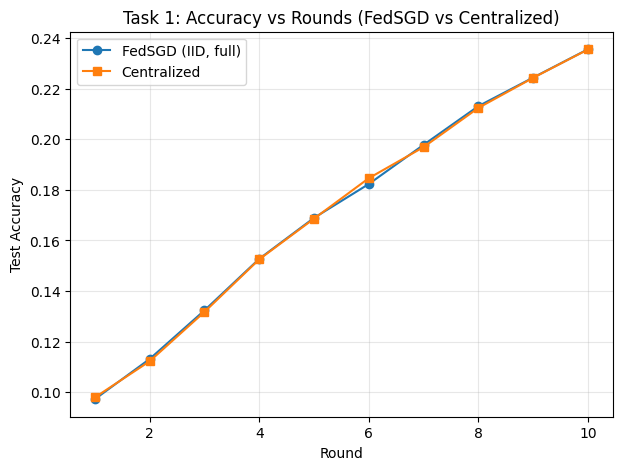

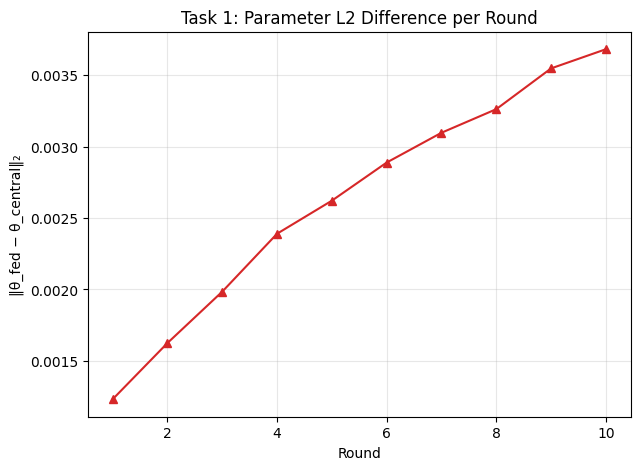

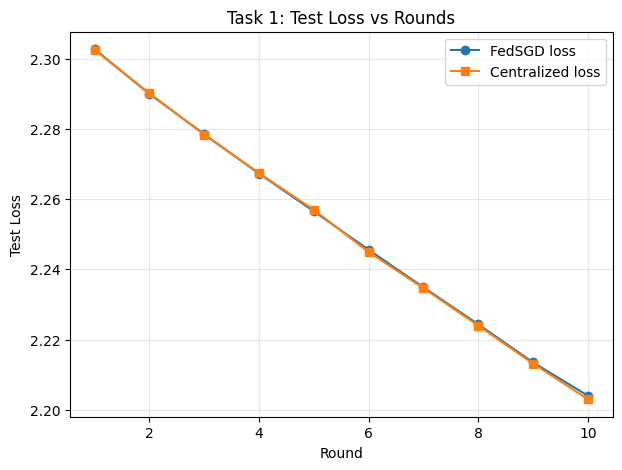

Saved figures to:
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task1_accuracy.png
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task1_param_diff.png
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task1_loss.png


In [ ]:
# # =======================================
# # 9) Plot Results & Save figures to Drive
# # =======================================
# # Load arrays for plotting
# rounds = [r["round"] for r in logs]
# fed_acc = [r["fed_test_acc"] for r in logs]
# cen_acc = [r["central_test_acc"] for r in logs]
# l2diff = [r["l2_param_diff"] for r in logs]
# fed_loss = [r["fed_test_loss"] for r in logs]
# cen_loss = [r["central_test_loss"] for r in logs]

# # Plot 1: Accuracy vs Rounds
# plt.figure(figsize=(7,5))
# plt.plot(rounds, fed_acc, marker='o', label="FedSGD (IID, full)")
# plt.plot(rounds, cen_acc, marker='s', label="Centralized")
# plt.xlabel("Round")
# plt.ylabel("Test Accuracy")
# plt.title("Task 1: Accuracy vs Rounds (FedSGD vs Centralized)")
# plt.grid(True, alpha=0.3)
# plt.legend()
# fig1_path = os.path.join(DRIVE_ROOT, "task1_accuracy.png")
# plt.savefig(fig1_path, dpi=150, bbox_inches='tight')
# plt.show()

# # Plot 2: L2 Parameter Difference vs Rounds
# plt.figure(figsize=(7,5))
# plt.plot(rounds, l2diff, marker='^', color='tab:red')
# plt.xlabel("Round")
# plt.ylabel("‖θ_fed − θ_central‖₂")
# plt.title("Task 1: Parameter L2 Difference per Round")
# plt.grid(True, alpha=0.3)
# fig2_path = os.path.join(DRIVE_ROOT, "task1_param_diff.png")
# plt.savefig(fig2_path, dpi=150, bbox_inches='tight')
# plt.show()

# # Plot 3: Test Loss vs Rounds (optional)
# plt.figure(figsize=(7,5))
# plt.plot(rounds, fed_loss, marker='o', label="FedSGD loss")
# plt.plot(rounds, cen_loss, marker='s', label="Centralized loss")
# plt.xlabel("Round")
# plt.ylabel("Test Loss")
# plt.title("Task 1: Test Loss vs Rounds")
# plt.grid(True, alpha=0.3)
# plt.legend()
# fig3_path = os.path.join(DRIVE_ROOT, "task1_loss.png")
# plt.savefig(fig3_path, dpi=150, bbox_inches='tight')
# plt.show()

# print("Saved figures to:")
# print(" -", fig1_path)
# print(" -", fig2_path)
print(" -", fig3_path)


In [ ]:
# # ==========================================
# # 10) Quick sanity: load and evaluate best models
# # ==========================================
# def load_and_eval(model_path, device):
#     m = init_model().to(device)
#     m.load_state_dict(torch.load(model_path, map_location=device))
#     loss, acc = evaluate(m, test_loader, device)
#     return loss, acc

# fed_best_loss, fed_best_acc = load_and_eval(best_fed, device)
# cen_best_loss, cen_best_acc = load_and_eval(best_cen, device)

# print(f"Best FedSGD (reloaded):   acc={fed_best_acc:.4f}, loss={fed_best_loss:.4f}")
# print(f"Best Centralized (reloaded): acc={cen_best_acc:.4f}, loss={cen_best_loss:.4f}")
# print("Models and results saved under:", DRIVE_ROOT)


Best FedSGD (reloaded):   acc=0.2356, loss=2.2040
Best Centralized (reloaded): acc=0.2355, loss=2.2030
Models and results saved under: /content/drive/MyDrive/ATML_PA4_Task1_FedSGD


# Task 2

In [ ]:
# ================================================================
# Task 2 — FedAvg implementation + experiments for K and f
# Reuses Task-1 code: model/init_model, loaders, evaluate, device, DRIVE_ROOT
# ================================================================

import os, time, math, copy, csv, random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# ---------- Helpers reused/extended ----------
def flatten_params(model: nn.Module):
    return torch.cat([p.detach().view(-1).cpu() for p in model.parameters()])

def l2_param_distance(a: nn.Module, b: nn.Module):
    return torch.norm(flatten_params(a) - flatten_params(b), p=2).item()

def model_num_bytes(model: nn.Module):
    # Params + buffers (e.g., running stats) for comm accounting
    n_bytes = 0
    for p in model.parameters():
        n_bytes += p.numel() * p.element_size()
    for b in model.buffers():
        n_bytes += b.numel() * b.element_size()
    return n_bytes

# --- BN buffer aggregation (safe if you use BatchNorm; no-op for GroupNorm) ---
def extract_bn_buffers(model):
    rms, rvs, nbts = [], [], []
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            rms.append(m.running_mean.detach().clone())
            rvs.append(m.running_var.detach().clone())
            nbts.append(m.num_batches_tracked.detach().clone())
    return rms, rvs, nbts

def set_bn_buffers(model, rms, rvs, nbts):
    i = 0
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.running_mean.copy_(rms[i])
            m.running_var.copy_(rvs[i])
            m.num_batches_tracked.copy_(nbts[i])
            i += 1

def aggregate_bn_buffers(participating_bn, weights):
    """participating_bn: list of (rms, rvs, nbts); weights: same length, sum to 1"""
    if len(participating_bn) == 0 or len(participating_bn[0][0]) == 0:
        return None
    num_bn = len(participating_bn[0][0])
    agg_rms = [torch.zeros_like(participating_bn[0][0][k]) for k in range(num_bn)]
    agg_rvs = [torch.zeros_like(participating_bn[0][1][k]) for k in range(num_bn)]
    # Initialize agg_nbts as float to avoid type casting issues during aggregation
    agg_nbts = [torch.zeros_like(participating_bn[0][2][k], dtype=torch.float32) for k in range(num_bn)]

    for (rms, rvs, nbts), w in zip(participating_bn, weights):
        for k in range(num_bn):
            agg_rms[k] += w * rms[k]
            agg_rvs[k] += w * rvs[k]
            # Aggregate num_batches_tracked as float
            agg_nbts[k] += w * nbts[k].float()
    # num_batches_tracked must be integer, convert back to long after aggregation
    agg_nbts = [x.round().to(dtype=torch.long) for x in agg_nbts]

    return agg_rms, agg_rvs, agg_nbts

# ---------- One FedAvg communication round ----------
@torch.no_grad()
def copy_model(src: nn.Module, dst: nn.Module):
    dst.load_state_dict(copy.deepcopy(src.state_dict()))

def client_local_train(model, loader, epochs, lr, momentum, weight_decay, device):
    """Standard local SGD on client's data for 'epochs'."""
    model.train()
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    ce = nn.CrossEntropyLoss()
    for _ in range(epochs):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = ce(logits, yb)
            loss.backward()
            opt.step()

def fedavg_round(global_model,
                 client_loaders,
                 client_sizes,
                 K=5,
                 client_fraction=1.0,
                 lr=0.01,
                 momentum=0.9,
                 weight_decay=5e-4,
                 device="cuda"):
    """
    Returns:
      new_global_model, drift_value, comm_stats (bytes_down, bytes_up), participating_ids
    """
    M = len(client_loaders)
    n_participate = max(1, int(round(client_fraction * M)))
    client_ids = list(range(M))
    random.shuffle(client_ids)
    selected = client_ids[:n_participate]

    # Bytes: send global model to each selected client; receive updated model back
    bytes_model = model_num_bytes(global_model)
    bytes_down = bytes_model * n_participate
    bytes_up   = bytes_model * n_participate

    # Save θ_g^t
    theta_g_t = copy.deepcopy(global_model.state_dict())

    # Per-client train
    client_models = []
    client_bn_bufs = []
    for i in selected:
        local_model = copy.deepcopy(global_model).to(device)
        client_local_train(local_model, client_loaders[i], epochs=K,
                           lr=lr, momentum=momentum, weight_decay=weight_decay, device=device)
        client_models.append((i, local_model))
        # collect BN buffers if any
        client_bn_bufs.append(extract_bn_buffers(local_model))

    # Weighted average of client weights (Ni / N_selected)
    N_selected = sum(client_sizes[i] for i in selected)
    new_state = copy.deepcopy(global_model.state_dict())
    for k in new_state.keys():
        # Ensure that num_batches_tracked is handled correctly during aggregation
        if 'num_batches_tracked' in k:
            new_state[k] = torch.zeros_like(new_state[k], dtype=torch.float)
        else:
            new_state[k].zero_()


    for (i, local_model) in client_models:
        wi = client_sizes[i] / N_selected
        local_sd = local_model.state_dict()
        for k in new_state.keys():
            if 'num_batches_tracked' in k:
                new_state[k] += wi * local_sd[k].float()
            else:
                new_state[k] += wi * local_sd[k]

    # Convert num_batches_tracked back to long after aggregation
    for k in new_state.keys():
        if 'num_batches_tracked' in k:
             new_state[k] = new_state[k].round().to(dtype=torch.long)

    # Update global
    global_model.load_state_dict(new_state)

    # Aggregate BN buffers for evaluation consistency (if BN exists)
    weights = [(client_sizes[i] / N_selected) for i, _ in client_models]
    agg = aggregate_bn_buffers(client_bn_bufs, weights)
    if agg is not None:
        set_bn_buffers(global_model, *agg)


    # Drift: average L2 ||θ_i^K − θ_g^t|| over selected clients
    # Compute using flattened vectors for stability
    with torch.no_grad():
        # reconstruct θ_g^t as a model to reuse l2 helper
        model_g_t = copy.deepcopy(global_model).to(device)
        model_g_t.load_state_dict(theta_g_t)
        drift_vals = []
        for _, local_model in client_models:
            drift_vals.append(l2_param_distance(local_model, model_g_t))
        drift = float(np.mean(drift_vals)) if drift_vals else 0.0

    return global_model, drift, (bytes_down, bytes_up), selected

In [ ]:
# ================================================================
# Runner utilities for Task 2 experiments
# ================================================================
def run_fedavg_experiment(config, tag, save_dir):
    """
    config: dict(
      rounds, K, f, lr, momentum, wd, seeds, eval_every
    )
    Returns logs (list of dict), path to CSV, and final model path.
    """
    os.makedirs(save_dir, exist_ok=True)
    csv_path = os.path.join(save_dir, f"{tag}_logs.csv")
    model_path = os.path.join(save_dir, f"{tag}_final_model.pt")

    logs = []
    bytes_total_down, bytes_total_up = 0, 0

    for seed in config["seeds"]:
        random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

        # fresh init (use your saved init if available to keep same start across runs)
        global_model = init_model().to(device)
        init_path = os.path.join(DRIVE_ROOT, "init_weights_task1.pt")
        if os.path.exists(init_path):
            global_model.load_state_dict(torch.load(init_path, map_location=device))

        R = config["rounds"]
        K = config["K"]
        f = config["f"]
        lr = config["lr"]
        momentum = config["momentum"]
        wd = config["weight_decay"]
        eval_every = config.get("eval_every", 1)

        # Per-seed log
        for t in range(1, R + 1):
            t0 = time.time()

            global_model, drift, (bytes_down, bytes_up), selected = fedavg_round(
                global_model,
                client_loaders=client_loaders,
                client_sizes=client_sizes,
                K=K, client_fraction=f,
                lr=lr, momentum=momentum, weight_decay=wd,
                device=device
            )
            bytes_total_down += bytes_down
            bytes_total_up   += bytes_up

            # Evaluate
            if (t % eval_every) == 0 or (t == R):
                test_loss, test_acc = evaluate(global_model, test_loader, device)
            else:
                test_loss, test_acc = float("nan"), float("nan")

            row = {
                "seed": seed, "round": t,
                "K": K, "f": f,
                "test_loss": test_loss,
                "test_acc": test_acc,
                "drift_l2": drift,
                "bytes_down": bytes_down,
                "bytes_up": bytes_up,
                "cum_bytes_down": bytes_total_down,
                "cum_bytes_up": bytes_total_up,
                "time_sec": time.time() - t0,
                "participating": len(selected)
            }
            logs.append(row)
            if not math.isnan(test_acc):
                print(f"[{tag}] seed={seed} round={t:02d}  acc={test_acc:.4f}  drift={drift:.4f}  "
                      f"down={bytes_down/1e6:.2f}MB up={bytes_up/1e6:.2f}MB")

        # Save per-seed checkpoint (last round)
        torch.save(global_model.state_dict(), model_path)

    # Write CSV
    if logs:
        with open(csv_path, "w", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=list(logs[0].keys()))
            writer.writeheader()
            writer.writerows(logs)

    print("Saved:", csv_path)
    print("Saved model:", model_path)
    return logs, csv_path, model_path


In [ ]:
# # ================================================================
# # Task 2A: Vary K with full participation (f=1.0)
# # ================================================================
# import pandas as pd
# import matplotlib.pyplot as plt

# SAVE_DIR_K = os.path.join(DRIVE_ROOT, "task2_K_sweep")
# os.makedirs(SAVE_DIR_K, exist_ok=True)

# common_cfg = {
#     "rounds": 30,            # can bump to 50 if you have time
#     "f": 1.0,                # full participation
#     "lr": 0.05,              # practical settings to get visible progress
#     "momentum": 0.9,
#     "weight_decay": 5e-4,
#     "seeds": [0],            # you can do [0,1,2] later
#     "eval_every": 1,
# }

# K_values = [1, 5, 10, 20]
# results_K = {}

# for K in K_values:
#     cfg = dict(common_cfg)
#     cfg["K"] = K
#     tag = f"K{K}_f1p0"
#     logs, csv_path, model_path = run_fedavg_experiment(cfg, tag=tag, save_dir=SAVE_DIR_K)
#     results_K[K] = (logs, csv_path, model_path)

# # Plot Accuracy vs Rounds (K sweep)
# plt.figure(figsize=(7.2,5))
# for K in K_values:
#     logs = results_K[K][0]
#     df = pd.DataFrame(logs)
#     # average over seeds if multiple; here single seed
#     acc_curve = df.groupby("round")["test_acc"].mean()
#     plt.plot(acc_curve.index, acc_curve.values, label=f"K={K}")
# plt.xlabel("Round")
# plt.ylabel("Global Test Accuracy")
# plt.title("FedAvg: Accuracy vs Rounds (varying K, f=1.0)")
# plt.grid(True, alpha=0.3)
# plt.legend()
# fig_path = os.path.join(SAVE_DIR_K, "task2_K_sweep_accuracy.png")
# plt.savefig(fig_path, dpi=150, bbox_inches='tight')
# plt.show()

# # Plot Drift vs Rounds (K sweep)
# plt.figure(figsize=(7.2,5))
# for K in K_values:
#     logs = results_K[K][0]
#     df = pd.DataFrame(logs)
#     drift_curve = df.groupby("round")["drift_l2"].mean()
#     plt.plot(drift_curve.index, drift_curve.values, label=f"K={K}")
# plt.xlabel("Round")
# plt.ylabel("Avg Drift ‖θ_i^K − θ_g^t‖₂")
# plt.title("FedAvg: Drift vs Rounds (varying K, f=1.0)")
# plt.grid(True, alpha=0.3)
# plt.legend()
# fig_path = os.path.join(SAVE_DIR_K, "task2_K_sweep_drift.png")
# plt.savefig(fig_path, dpi=150, bbox_inches='tight')
# plt.show()

# print("Saved K-sweep figures to:", SAVE_DIR_K)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 

[K5_f1p0] seed=0 round=01  acc=0.2450  drift=6.0240  down=10.91MB up=10.91MB
[K5_f1p0] seed=0 round=02  acc=0.3502  drift=4.0278  down=10.91MB up=10.91MB
[K5_f1p0] seed=0 round=03  acc=0.4686  drift=3.4732  down=10.91MB up=10.91MB
[K5_f1p0] seed=0 round=04  acc=0.5256  drift=3.2170  down=10.91MB up=10.91MB
[K5_f1p0] seed=0 round=05  acc=0.5656  drift=3.0620  down=10.91MB up=10.91MB
[K5_f1p0] seed=0 round=06  acc=0.5953  drift=3.0042  down=10.91MB up=10.91MB
[K5_f1p0] seed=0 round=07  acc=0.6234  drift=2.9869  down=10.91MB up=10.91MB
[K5_f1p0] seed=0 round=08  acc=0.6342  drift=2.9773  down=10.91MB up=10.91MB
[K5_f1p0] seed=0 round=09  acc=0.6562  drift=2.9895  down=10.91MB up=10.91MB
[K5_f1p0] seed=0 round=10  acc=0.6692  drift=2.9867  down=10.91MB up=10.91MB
[K5_f1p0] seed=0 round=11  acc=0.6625  drift=2.9671  down=10.91MB up=10.91MB
[K5_f1p0] seed=0 round=12  acc=0.6692  drift=3.0061  down=10.91MB up=10.91MB
[K5_f1p0] seed=0 round=13  acc=0.6855  drift=3.0703  down=10.91MB up=10.91MB

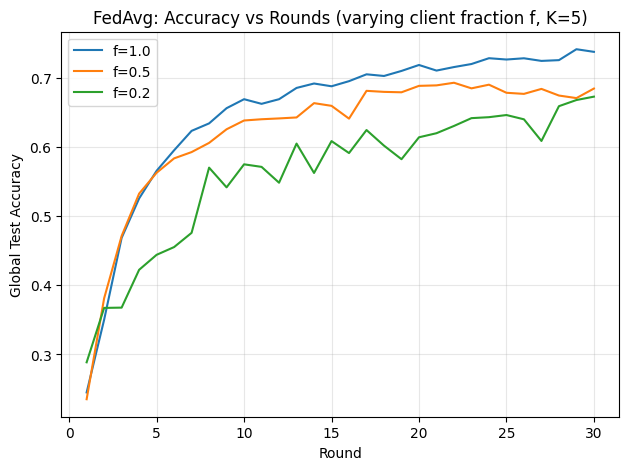

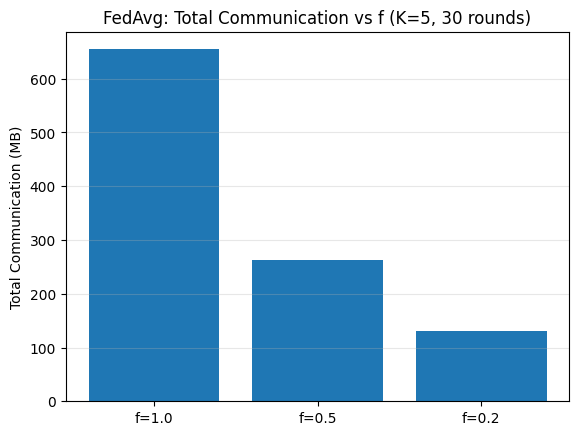

Saved f-sweep figures to: /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task2_f_sweep


In [ ]:
# # ================================================================
# # Task 2B: Vary client sampling fraction f with fixed K=5
# # ================================================================
# SAVE_DIR_F = os.path.join(DRIVE_ROOT, "task2_f_sweep")
# os.makedirs(SAVE_DIR_F, exist_ok=True)

# common_cfg_f = {
#     "rounds": 30,
#     "K": 1,                  # fixed local epochs
#     "lr": 0.05,
#     "momentum": 0.9,
#     "weight_decay": 5e-4,
#     "seeds": [0],            # do more seeds later if desired
#     "eval_every": 1,
# }

# f_values = [1.0, 0.5, 0.2]
# results_f = {}

# for f in f_values:
#     cfg = dict(common_cfg_f)
#     cfg["f"] = f
#     tag = f"K1_f{str(f).replace('.','p')}"
#     logs, csv_path, model_path = run_fedavg_experiment(cfg, tag=tag, save_dir=SAVE_DIR_F)
#     results_f[f] = (logs, csv_path, model_path)

# # Plot Accuracy vs Rounds (f sweep)
# import pandas as pd
# plt.figure(figsize=(7.2,5))
# for f in f_values:
#     logs = results_f[f][0]
#     df = pd.DataFrame(logs)
#     acc_curve = df.groupby("round")["test_acc"].mean()
#     plt.plot(acc_curve.index, acc_curve.values, label=f"f={f}")
# plt.xlabel("Round")
# plt.ylabel("Global Test Accuracy")
# plt.title("FedAvg: Accuracy vs Rounds (varying client fraction f, K=5)")
# plt.grid(True, alpha=0.3)
# plt.legend()
# fig_path = os.path.join(SAVE_DIR_F, "task2_f_sweep_accuracy.png")
# plt.savefig(fig_path, dpi=150, bbox_inches='tight')
# plt.show()

# # Communication bar chart (total MB per setting)
# totals = []
# labels = []
# for f in f_values:
#     df = pd.DataFrame(results_f[f][0])
#     # last round cumulative bytes
#     last = df.sort_values(["seed", "round"]).groupby("seed").tail(1)
#     mb_total = ((last["cum_bytes_down"] + last["cum_bytes_up"]).mean()) / 1e6
#     totals.append(mb_total)
#     labels.append(f"f={f}")

# plt.figure(figsize=(6.5,4.8))
# plt.bar(labels, totals)
# plt.ylabel("Total Communication (MB)")
# plt.title("FedAvg: Total Communication vs f (K=1, 30 rounds)")
# plt.grid(True, axis='y', alpha=0.3)
# fig_path = os.path.join(SAVE_DIR_F, "task2_f_sweep_comm.png")
# plt.savefig(fig_path, dpi=150, bbox_inches='tight')
# plt.show()

# print("Saved f-sweep figures to:", SAVE_DIR_F)


# Task 3

In [ ]:
# ================================================================
# Task 3 — Dirichlet(α) non-IID partitioning + FedAvg runs
# Saves per-client class distributions and training curves to Drive
# ================================================================

import os, json, math, copy, time, random
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Subset, DataLoader
from torchvision import datasets

# Where to save Task 3 artifacts
TASK3_DIR = os.path.join(DRIVE_ROOT, "task3_nonIID_dirichlet")
os.makedirs(TASK3_DIR, exist_ok=True)

# Re-load CIFAR-10 train set with *training* transform (same as earlier)
root_data = "/content/data"
train_set_full = datasets.CIFAR10(root=root_data, train=True, download=True, transform=train_tf)

NUM_CLIENTS = 5  # fixed for this assignment

def dirichlet_split_cifar10(train_set, num_clients, alpha, seed=1234, min_size_per_client=10):
    """
    Returns:
      client_indices: list[list[int]] indices per client
      class_hist: list[np.array shape (10,)] class counts per client
    """
    rng = np.random.default_rng(seed)
    y = np.array(train_set.targets)  # CIFAR-10 labels
    num_classes = 10

    # collect indices for each class
    class_indices = [np.where(y == c)[0] for c in range(num_classes)]
    for c in range(num_classes):
        rng.shuffle(class_indices[c])

    # draw class proportions from Dirichlet for each class
    # alpha can be a scalar; use symmetric Dir
    client_indices = [[] for _ in range(num_clients)]
    for c in range(num_classes):
        n_c = len(class_indices[c])
        if alpha >= 50:  # treat as IID split
            # uniform proportions (avoid floating point artifacts)
            props = np.ones(num_clients) / num_clients
        else:
            props = rng.dirichlet(alpha * np.ones(num_clients))
        # turn proportions into counts that sum to n_c
        counts = np.floor(props * n_c).astype(int)
        # adjust rounding to hit exact n_c
        while counts.sum() < n_c:
            counts[rng.integers(0, num_clients)] += 1
        while counts.sum() > n_c:
            j = rng.integers(0, num_clients)
            if counts[j] > 0:
                counts[j] -= 1

        start = 0
        for i in range(num_clients):
            idxs = class_indices[c][start:start+counts[i]]
            client_indices[i].extend(idxs.tolist())
            start += counts[i]

    # ensure each client has at least min_size_per_client samples
    # (very small alpha can cause empties; this guard is light)
    for i in range(num_clients):
        if len(client_indices[i]) < min_size_per_client:
            # simple fix: borrow from the largest client
            sizes = [len(ci) for ci in client_indices]
            donor = int(np.argmax(sizes))
            need = min_size_per_client - len(client_indices[i])
            take = client_indices[donor][:need]
            client_indices[i].extend(take)
            client_indices[donor] = client_indices[donor][need:]

    # shuffle per client for loader order
    for i in range(num_clients):
        rng.shuffle(client_indices[i])

    # class histogram per client
    class_hist = []
    for i in range(num_clients):
        labels_i = y[np.array(client_indices[i])]
        hist = np.bincount(labels_i, minlength=num_classes)
        class_hist.append(hist)

    return client_indices, class_hist

def build_client_loaders_from_indices(train_set, client_indices, batch_size=64, num_workers=2):
    client_subsets = [Subset(train_set, idxs) for idxs in client_indices]
    client_loaders = [
        DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
        for ds in client_subsets
    ]
    client_sizes = [len(ds) for ds in client_subsets]
    return client_loaders, client_sizes

def save_class_distribution(alpha, class_hist, client_sizes, out_dir):
    df_rows = []
    for i, hist in enumerate(class_hist):
        row = {"client": i, "total": int(client_sizes[i])}
        for c in range(10):
            row[f"class_{c}"] = int(hist[c])
            row[f"pct_{c}"] = float(hist[c]) / max(1, client_sizes[i])
        df_rows.append(row)
    df = pd.DataFrame(df_rows)
    csv_path = os.path.join(out_dir, f"class_distribution_alpha_{alpha}.csv")
    df.to_csv(csv_path, index=False)

    json_path = os.path.join(out_dir, f"class_distribution_alpha_{alpha}.json")
    with open(json_path, "w") as f:
        json.dump(df_rows, f, indent=2)

    print(f"[α={alpha}] Saved per-client class distribution to:")
    print(" -", csv_path)
    print(" -", json_path)
    return df


In [ ]:
# ================================================================
# Runner for Task 3: iterate α, rebuild loaders, run FedAvg
# (reuses run_fedavg_experiment from Task 2)
# ================================================================
import matplotlib.pyplot as plt

def run_task3_dirichlet_experiments(
    alphas=(100,20,1.0, 0.2, 0.05),
    K=5,
    rounds=30,            # 30 works; 50 gives clearer separation
    lr=0.05,
    momentum=0.9,
    weight_decay=5e-4,
    eval_every=1,
    seeds=(0,),           # you can do (0,1,2) later
    partition_seed=2025,  # controls the Dirichlet split
    batch_size=64,
):
    all_results = {}
    for alpha in alphas:
        print("\n" + "="*70)
        print(f"Building Dirichlet split α={alpha} for {NUM_CLIENTS} clients (seed={partition_seed})")
        print("="*70)

        # 1) Build split + loaders
        split_dir = os.path.join(TASK3_DIR, f"alpha_{alpha}")
        os.makedirs(split_dir, exist_ok=True)

        client_idxs, class_hist = dirichlet_split_cifar10(
            train_set_full, num_clients=NUM_CLIENTS, alpha=alpha, seed=partition_seed
        )
        client_loaders_local, client_sizes_local = build_client_loaders_from_indices(
            train_set_full, client_idxs, batch_size=batch_size, num_workers=2
        )
        # Save/print which client got which classes
        dist_df = save_class_distribution(alpha, class_hist, client_sizes_local, split_dir)
        display(dist_df)  # Colab pretty display

        # 2) Monkey-patch globals used by run_fedavg_experiment (from Task 2)
        #    (keeps code minimal—alternatively you can refactor the runner to accept loaders explicitly)
        global client_loaders, client_sizes
        client_loaders = client_loaders_local
        client_sizes   = client_sizes_local

        # 3) Configure and run FedAvg (fixed K, full participation)
        cfg = {
            "rounds": rounds,
            "K": K,
            "f": 1.0,
            "lr": lr,
            "momentum": momentum,
            "weight_decay": weight_decay,
            "seeds": list(seeds),
            "eval_every": eval_every,
        }
        tag = f"dirichlet_alpha_{alpha}_K{K}_f1p0"
        logs, csv_path, model_path = run_fedavg_experiment(cfg, tag=tag, save_dir=split_dir)
        all_results[alpha] = (logs, csv_path, model_path, split_dir)

    # 4) Plots across α
    plt.figure(figsize=(7.5,5.2))
    for alpha in alphas:
        logs = all_results[alpha][0]
        df = pd.DataFrame(logs)
        acc_curve = df.groupby("round")["test_acc"].mean()
        plt.plot(acc_curve.index, acc_curve.values, label=f"α={alpha}")
    plt.xlabel("Round"); plt.ylabel("Global Test Accuracy")
    plt.title(f"FedAvg: Accuracy vs Rounds for Dirichlet α (K={K}, f=1.0)")
    plt.grid(True, alpha=0.3); plt.legend()
    fig_acc = os.path.join(TASK3_DIR, f"task3_accuracy_K{K}.png")
    plt.savefig(fig_acc, dpi=150, bbox_inches='tight')
    plt.show()

    # Optional: drift curves
    plt.figure(figsize=(7.5,5.2))
    for alpha in alphas:
        logs = all_results[alpha][0]
        df = pd.DataFrame(logs)
        drift_curve = df.groupby("round")["drift_l2"].mean()
        plt.plot(drift_curve.index, drift_curve.values, label=f"α={alpha}")
    plt.xlabel("Round"); plt.ylabel("Avg Drift ‖θ_i^K − θ_g^t‖₂")
    plt.title(f"FedAvg: Drift vs Rounds for Dirichlet α (K={K}, f=1.0)")
    plt.grid(True, alpha=0.3); plt.legend()
    fig_drift = os.path.join(TASK3_DIR, f"task3_drift_K{K}.png")
    plt.savefig(fig_drift, dpi=150, bbox_inches='tight')
    plt.show()

    print("Saved Task 3 figures to:")
    print(" -", fig_acc)
    print(" -", fig_drift)

    return all_results


In [ ]:
# # =========================
# # Run Task 3
# # =========================
# # You can reduce rounds to 30 if compute is tight.
# task3_results = run_task3_dirichlet_experiments(
#     alphas=(100,20 ,1.0, 0.2, 0.05),
#     K=5,
#     rounds=30,
#     lr=0.05,
#     momentum=0.9,
#     weight_decay=5e-4,
#     eval_every=1,
#     seeds=(0,),          # bump to (0,1,2) later for mean ± std
#     partition_seed=2025, # changing this changes "who got which classes"
#     batch_size=64,
# )



Building Dirichlet split α=100 for 5 clients (seed=2025)
[α=100] Saved per-client class distribution to:
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task3_nonIID_dirichlet/alpha_100/class_distribution_alpha_100.csv
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task3_nonIID_dirichlet/alpha_100/class_distribution_alpha_100.json


,client,total,class_0,pct_0,class_1,pct_1,class_2,pct_2,class_3,pct_3,...,class_5,pct_5,class_6,pct_6,class_7,pct_7,class_8,pct_8,class_9,pct_9
0,0,10000,1000,0.1,1000,0.1,1000,0.1,1000,0.1,...,1000,0.1,1000,0.1,1000,0.1,1000,0.1,1000,0.1
1,1,10000,1000,0.1,1000,0.1,1000,0.1,1000,0.1,...,1000,0.1,1000,0.1,1000,0.1,1000,0.1,1000,0.1
2,2,10000,1000,0.1,1000,0.1,1000,0.1,1000,0.1,...,1000,0.1,1000,0.1,1000,0.1,1000,0.1,1000,0.1
3,3,10000,1000,0.1,1000,0.1,1000,0.1,1000,0.1,...,1000,0.1,1000,0.1,1000,0.1,1000,0.1,1000,0.1
4,4,10000,1000,0.1,1000,0.1,1000,0.1,1000,0.1,...,1000,0.1,1000,0.1,1000,0.1,1000,0.1,1000,0.1


[dirichlet_alpha_100_K5_f1p0] seed=0 round=01  acc=0.1008  drift=13.8437  down=10.91MB up=10.91MB
[dirichlet_alpha_100_K5_f1p0] seed=0 round=02  acc=0.6334  drift=13.9053  down=10.91MB up=10.91MB
[dirichlet_alpha_100_K5_f1p0] seed=0 round=03  acc=0.6761  drift=11.5895  down=10.91MB up=10.91MB
[dirichlet_alpha_100_K5_f1p0] seed=0 round=04  acc=0.7042  drift=11.1467  down=10.91MB up=10.91MB
[dirichlet_alpha_100_K5_f1p0] seed=0 round=05  acc=0.7169  drift=11.0901  down=10.91MB up=10.91MB
[dirichlet_alpha_100_K5_f1p0] seed=0 round=06  acc=0.7262  drift=11.1304  down=10.91MB up=10.91MB
[dirichlet_alpha_100_K5_f1p0] seed=0 round=07  acc=0.7382  drift=11.2380  down=10.91MB up=10.91MB
[dirichlet_alpha_100_K5_f1p0] seed=0 round=08  acc=0.7452  drift=11.2665  down=10.91MB up=10.91MB
[dirichlet_alpha_100_K5_f1p0] seed=0 round=09  acc=0.7429  drift=11.4133  down=10.91MB up=10.91MB
[dirichlet_alpha_100_K5_f1p0] seed=0 round=10  acc=0.7539  drift=11.4107  down=10.91MB up=10.91MB
[dirichlet_alpha_100

,client,total,class_0,pct_0,class_1,pct_1,class_2,pct_2,class_3,pct_3,...,class_5,pct_5,class_6,pct_6,class_7,pct_7,class_8,pct_8,class_9,pct_9
0,0,10201,1138,0.111558,1044,0.102343,1062,0.104107,998,0.097834,...,1067,0.104598,1061,0.104009,799,0.078326,1029,0.100872,900,0.088227
1,1,10912,973,0.089168,1271,0.116477,936,0.085777,1017,0.093200,...,949,0.086968,1058,0.096957,1185,0.108596,846,0.077529,1300,0.119135
2,2,9210,658,0.071444,597,0.064821,1071,0.116287,828,0.089902,...,969,0.105212,1023,0.111075,1338,0.145277,1078,0.117047,915,0.099349
3,3,9796,972,0.099224,1039,0.106064,937,0.095651,1200,0.122499,...,1005,0.102593,920,0.093916,792,0.080849,1223,0.124847,871,0.088914
4,4,9881,1259,0.127416,1049,0.106163,994,0.100597,957,0.096853,...,1010,0.102216,938,0.094930,886,0.089667,824,0.083392,1014,0.102621


KeyboardInterrupt: 


Building Dirichlet split α=1.0 for 5 clients (seed=2025)
[α=1.0] Saved per-client class distribution to:
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task3_nonIID_dirichlet/alpha_1.0/class_distribution_alpha_1.0.csv
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task3_nonIID_dirichlet/alpha_1.0/class_distribution_alpha_1.0.json


,client,total,class_0,pct_0,class_1,pct_1,class_2,pct_2,class_3,pct_3,...,class_5,pct_5,class_6,pct_6,class_7,pct_7,class_8,pct_8,class_9,pct_9
0,0,11678,1201,0.102843,1208,0.103442,215,0.018411,1172,0.100360,...,312,0.026717,2149,0.184021,895,0.076640,587,0.050265,1187,0.101644
1,1,10620,1258,0.118456,1674,0.157627,918,0.086441,6,0.000565,...,857,0.080697,1163,0.109510,987,0.092938,693,0.065254,1253,0.117985
2,2,10814,496,0.045866,1016,0.093952,2374,0.219530,599,0.055391,...,2300,0.212687,219,0.020252,1660,0.153505,25,0.002312,2091,0.193360
3,3,5969,1072,0.179595,905,0.151617,223,0.037360,1679,0.281287,...,203,0.034009,83,0.013905,718,0.120288,288,0.048249,458,0.076730
4,4,10919,973,0.089111,197,0.018042,1270,0.116311,1544,0.141405,...,1328,0.121623,1386,0.126935,740,0.067772,3407,0.312025,11,0.001007


[dirichlet_alpha_1.0_K3_f1p0] seed=0 round=02  acc=0.4559  drift=9.8261  down=10.91MB up=10.91MB
[dirichlet_alpha_1.0_K3_f1p0] seed=0 round=04  acc=0.5899  drift=7.9991  down=10.91MB up=10.91MB
[dirichlet_alpha_1.0_K3_f1p0] seed=0 round=06  acc=0.6403  drift=7.7800  down=10.91MB up=10.91MB
[dirichlet_alpha_1.0_K3_f1p0] seed=0 round=08  acc=0.6520  drift=7.9650  down=10.91MB up=10.91MB
[dirichlet_alpha_1.0_K3_f1p0] seed=0 round=10  acc=0.6738  drift=8.0987  down=10.91MB up=10.91MB
[dirichlet_alpha_1.0_K3_f1p0] seed=0 round=12  acc=0.6877  drift=8.1004  down=10.91MB up=10.91MB
[dirichlet_alpha_1.0_K3_f1p0] seed=0 round=14  acc=0.7148  drift=8.1396  down=10.91MB up=10.91MB
[dirichlet_alpha_1.0_K3_f1p0] seed=0 round=16  acc=0.7208  drift=8.1721  down=10.91MB up=10.91MB
[dirichlet_alpha_1.0_K3_f1p0] seed=0 round=18  acc=0.7132  drift=8.2230  down=10.91MB up=10.91MB
[dirichlet_alpha_1.0_K3_f1p0] seed=0 round=20  acc=0.7248  drift=8.2201  down=10.91MB up=10.91MB
[dirichlet_alpha_1.0_K3_f1p0] 

,client,total,class_0,pct_0,class_1,pct_1,class_2,pct_2,class_3,pct_3,...,class_5,pct_5,class_6,pct_6,class_7,pct_7,class_8,pct_8,class_9,pct_9
0,0,12110,4385,0.362097,10,0.000826,4046,0.334104,3,0.000248,...,47,0.003881,1,0.000083,0,0.000000,3603,0.297523,15,0.001239
1,1,7198,31,0.004307,33,0.004585,5,0.000695,267,0.037094,...,62,0.008614,1267,0.176021,9,0.001250,1229,0.170742,4147,0.576132
2,2,6997,306,0.043733,4722,0.674861,11,0.001572,0,0.000000,...,99,0.014149,871,0.124482,4,0.000572,1,0.000143,70,0.010004
3,3,18300,24,0.001311,3,0.000164,937,0.051202,1420,0.077596,...,4708,0.257268,2831,0.154699,4392,0.240000,53,0.002896,1,0.000055
4,4,5395,254,0.047081,232,0.043003,1,0.000185,3310,0.613531,...,84,0.015570,30,0.005561,595,0.110287,114,0.021131,767,0.142169


[dirichlet_alpha_0.2_K3_f1p0] seed=0 round=02  acc=0.2251  drift=7.9751  down=10.91MB up=10.91MB
[dirichlet_alpha_0.2_K3_f1p0] seed=0 round=04  acc=0.4472  drift=7.2092  down=10.91MB up=10.91MB
[dirichlet_alpha_0.2_K3_f1p0] seed=0 round=06  acc=0.5227  drift=6.8224  down=10.91MB up=10.91MB
[dirichlet_alpha_0.2_K3_f1p0] seed=0 round=08  acc=0.5177  drift=6.7681  down=10.91MB up=10.91MB
[dirichlet_alpha_0.2_K3_f1p0] seed=0 round=10  acc=0.5621  drift=6.7765  down=10.91MB up=10.91MB
[dirichlet_alpha_0.2_K3_f1p0] seed=0 round=12  acc=0.5549  drift=6.7815  down=10.91MB up=10.91MB
[dirichlet_alpha_0.2_K3_f1p0] seed=0 round=14  acc=0.5553  drift=6.9103  down=10.91MB up=10.91MB
[dirichlet_alpha_0.2_K3_f1p0] seed=0 round=16  acc=0.5720  drift=6.7964  down=10.91MB up=10.91MB
[dirichlet_alpha_0.2_K3_f1p0] seed=0 round=18  acc=0.5683  drift=6.8152  down=10.91MB up=10.91MB
[dirichlet_alpha_0.2_K3_f1p0] seed=0 round=20  acc=0.5710  drift=6.8609  down=10.91MB up=10.91MB
[dirichlet_alpha_0.2_K3_f1p0] 

,client,total,class_0,pct_0,class_1,pct_1,class_2,pct_2,class_3,pct_3,...,class_5,pct_5,class_6,pct_6,class_7,pct_7,class_8,pct_8,class_9,pct_9
0,0,22913,1246,0.054380,4974,0.217082,4999,0.218173,0,0.000000,...,990,0.043207,4999,0.218173,930,0.040588,0,0.000000,124,0.005412
1,1,3381,1,0.000296,0,0.000000,0,0.000000,0,0.000000,...,110,0.032535,0,0.000000,3270,0.967169,0,0.000000,0,0.000000
2,2,3938,0,0.000000,1,0.000254,0,0.000000,0,0.000000,...,3893,0.988573,0,0.000000,0,0.000000,0,0.000000,44,0.011173
3,3,385,1,0.002597,25,0.064935,1,0.002597,9,0.023377,...,7,0.018182,1,0.002597,0,0.000000,0,0.000000,0,0.000000
4,4,19383,3752,0.193572,0,0.000000,0,0.000000,4991,0.257494,...,0,0.000000,0,0.000000,800,0.041273,5000,0.257958,4832,0.249291


[dirichlet_alpha_0.05_K3_f1p0] seed=0 round=02  acc=0.2761  drift=7.4159  down=10.91MB up=10.91MB
[dirichlet_alpha_0.05_K3_f1p0] seed=0 round=04  acc=0.4017  drift=6.3103  down=10.91MB up=10.91MB
[dirichlet_alpha_0.05_K3_f1p0] seed=0 round=06  acc=0.4229  drift=6.5879  down=10.91MB up=10.91MB
[dirichlet_alpha_0.05_K3_f1p0] seed=0 round=08  acc=0.4023  drift=7.7837  down=10.91MB up=10.91MB
[dirichlet_alpha_0.05_K3_f1p0] seed=0 round=10  acc=0.4453  drift=6.4620  down=10.91MB up=10.91MB
[dirichlet_alpha_0.05_K3_f1p0] seed=0 round=12  acc=0.5097  drift=6.4235  down=10.91MB up=10.91MB
[dirichlet_alpha_0.05_K3_f1p0] seed=0 round=14  acc=0.4944  drift=6.8780  down=10.91MB up=10.91MB
[dirichlet_alpha_0.05_K3_f1p0] seed=0 round=16  acc=0.4767  drift=6.5584  down=10.91MB up=10.91MB
[dirichlet_alpha_0.05_K3_f1p0] seed=0 round=18  acc=0.4791  drift=6.4491  down=10.91MB up=10.91MB
[dirichlet_alpha_0.05_K3_f1p0] seed=0 round=20  acc=0.3517  drift=8.2698  down=10.91MB up=10.91MB
[dirichlet_alpha_0.0

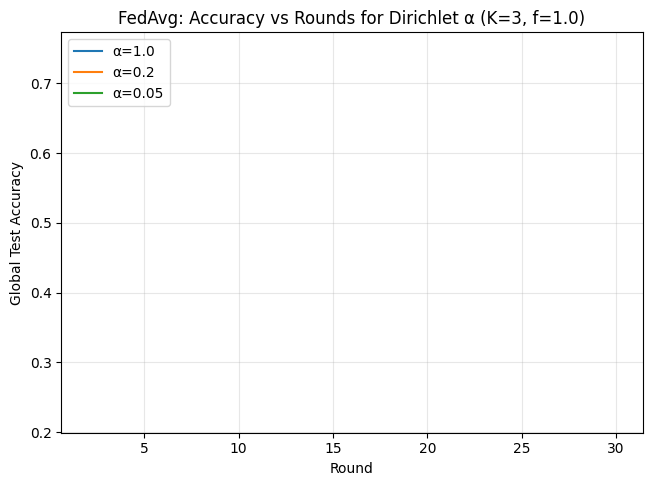

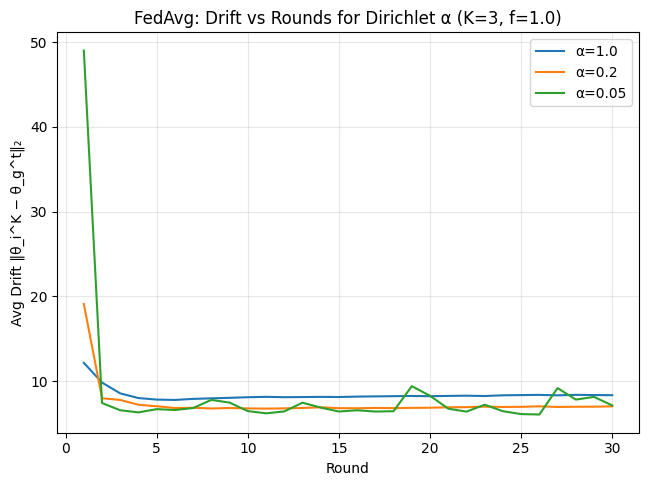

Saved Task 3 figures to:
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task3_nonIID_dirichlet/task3_accuracy_K3.png
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task3_nonIID_dirichlet/task3_drift_K3.png


In [ ]:
# # =========================
# # Run Task 3
# # =========================
# # You can reduce rounds to 30 if compute is tight.
# task3_update_results = run_task3_dirichlet_experiments(
#     alphas=(1.0, 0.2, 0.05),
#     K=3,
#     rounds=30,
#     lr=0.05,
#     momentum=0.9,
#     weight_decay=5e-4,
#     eval_every=2,
#     seeds=(0,),          # bump to (0,1,2) later for mean ± std
#     partition_seed=2025, # changing this changes "who got which classes"
#     batch_size=64,
# )


Building Dirichlet split α=0.01 for 5 clients (seed=777)
[α=0.01] Saved per-client class distribution to:
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task3_nonIID_dirichlet/alpha_0.01/class_distribution_alpha_0.01.csv
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task3_nonIID_dirichlet/alpha_0.01/class_distribution_alpha_0.01.json


,client,total,class_0,pct_0,class_1,pct_1,class_2,pct_2,class_3,pct_3,...,class_5,pct_5,class_6,pct_6,class_7,pct_7,class_8,pct_8,class_9,pct_9
0,0,10,1,0.100000,7,0.70000,0,0.00000,1,0.100000,...,0,0.00000,0,0.00000,0,0.000000,0,0.00000,0,0.0000
1,1,5002,0,0.000000,0,0.00000,1,0.00020,0,0.000000,...,1,0.00020,4999,0.99940,0,0.000000,1,0.00020,0,0.0000
2,2,12301,0,0.000000,0,0.00000,4999,0.40639,2302,0.187139,...,4999,0.40639,0,0.00000,1,0.000081,0,0.00000,0,0.0000
3,3,19992,0,0.000000,4993,0.24975,0,0.00000,0,0.000000,...,0,0.00000,1,0.00005,0,0.000000,4999,0.25005,5000,0.2501
4,4,12695,4999,0.393777,0,0.00000,0,0.00000,2697,0.212446,...,0,0.00000,0,0.00000,4999,0.393777,0,0.00000,0,0.0000


[dirichlet_alpha_0.01_K3_f1p0] seed=0 round=02  acc=0.2169  drift=7.1778  down=10.91MB up=10.91MB
[dirichlet_alpha_0.01_K3_f1p0] seed=0 round=04  acc=0.3290  drift=6.5016  down=10.91MB up=10.91MB
[dirichlet_alpha_0.01_K3_f1p0] seed=0 round=06  acc=0.3963  drift=6.1591  down=10.91MB up=10.91MB
[dirichlet_alpha_0.01_K3_f1p0] seed=0 round=08  acc=0.4231  drift=6.0147  down=10.91MB up=10.91MB
[dirichlet_alpha_0.01_K3_f1p0] seed=0 round=10  acc=0.4386  drift=6.0355  down=10.91MB up=10.91MB
[dirichlet_alpha_0.01_K3_f1p0] seed=0 round=12  acc=0.4684  drift=6.0134  down=10.91MB up=10.91MB
[dirichlet_alpha_0.01_K3_f1p0] seed=0 round=14  acc=0.4625  drift=6.0597  down=10.91MB up=10.91MB
[dirichlet_alpha_0.01_K3_f1p0] seed=0 round=16  acc=0.4707  drift=6.0077  down=10.91MB up=10.91MB
[dirichlet_alpha_0.01_K3_f1p0] seed=0 round=18  acc=0.5016  drift=6.0766  down=10.91MB up=10.91MB
[dirichlet_alpha_0.01_K3_f1p0] seed=0 round=20  acc=0.4593  drift=6.0573  down=10.91MB up=10.91MB
[dirichlet_alpha_0.0

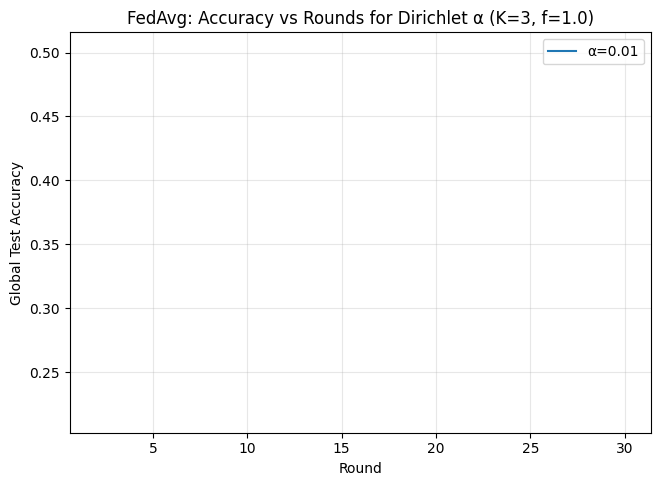

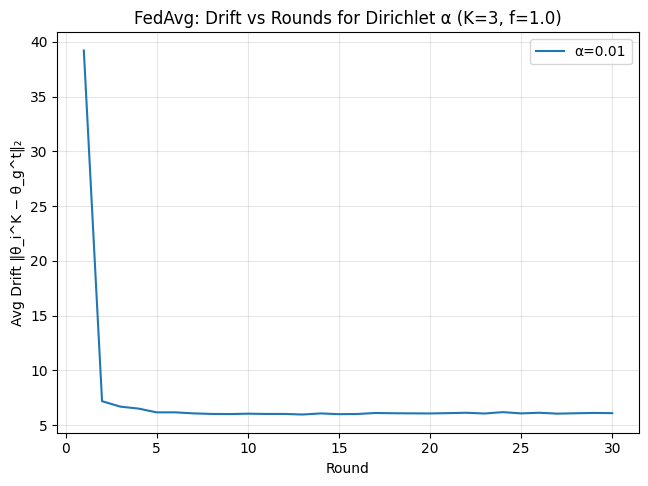

Saved Task 3 figures to:
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task3_nonIID_dirichlet/task3_accuracy_K3.png
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task3_nonIID_dirichlet/task3_drift_K3.png


In [ ]:
# =========================
# Run Task 3
# =========================
# You can reduce rounds to 30 if compute is tight.
task3_update2_results = run_task3_dirichlet_experiments(
    alphas=(0.01,),
    K=3,
    rounds=30,
    lr=0.05,
    momentum=0.9,
    weight_decay=5e-4,
    eval_every=2,
    seeds=(0,),          # bump to (0,1,2) later for mean ± std
    partition_seed=777, # changing this changes "who got which classes"
    batch_size=64,
)

# Task 4

Subtask 4.2

In [ ]:
# ================================================================
# Task 4.2 — SCAFFOLD implementation + experiments
# Prereqs from earlier cells:
#   - init_model, evaluate, device, DRIVE_ROOT, test_loader
#   - dirichlet_split_cifar10, build_client_loaders_from_indices, save_class_distribution
#   - (optional) BN helpers extract_bn_buffers, set_bn_buffers, aggregate_bn_buffers
# If you didn't keep BN helpers, the code below includes a safe copy.
# ================================================================

import os, time, math, copy, csv, random, json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

TASK42_DIR = os.path.join(DRIVE_ROOT, "task4_2_scaffold")
os.makedirs(TASK42_DIR, exist_ok=True)

# ---------- BN buffer helpers (no-op if your model uses GroupNorm) ----------
def extract_bn_buffers(model):
    rms, rvs, nbts = [], [], []
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            rms.append(m.running_mean.detach().clone())
            rvs.append(m.running_var.detach().clone())
            nbts.append(m.num_batches_tracked.detach().clone())
    return rms, rvs, nbts

def set_bn_buffers(model, rms, rvs, nbts):
    i = 0
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.running_mean.copy_(rms[i])
            m.running_var.copy_(rvs[i])
            m.num_batches_tracked.copy_(nbts[i])
            i += 1

def aggregate_bn_buffers(participating_bn, weights):
    if len(participating_bn) == 0 or len(participating_bn[0][0]) == 0:
        return None
    num_bn = len(participating_bn[0][0])
    agg_rms = [torch.zeros_like(participating_bn[0][0][k]) for k in range(num_bn)]
    agg_rvs = [torch.zeros_like(participating_bn[0][1][k]) for k in range(num_bn)]
    agg_nbts = [torch.zeros_like(participating_bn[0][2][k], dtype=torch.float32) for k in range(num_bn)]
    for (rms, rvs, nbts), w in zip(participating_bn, weights):
        for k in range(num_bn):
            agg_rms[k] += w * rms[k]
            agg_rvs[k] += w * rvs[k]
            agg_nbts[k] += w * nbts[k].float()
    agg_nbts = [x.round().to(dtype=torch.long) for x in agg_nbts]
    return agg_rms, agg_rvs, agg_nbts

# ---------- Small tensor-list helpers ----------
def flatten_params(model: nn.Module):
    return torch.cat([p.detach().view(-1).cpu() for p in model.parameters()])

def l2_param_distance(a: nn.Module, b: nn.Module):
    return torch.norm(flatten_params(a) - flatten_params(b), p=2).item()

def model_num_bytes(model: nn.Module):
    n_bytes = 0
    for p in model.parameters():
        n_bytes += p.numel() * p.element_size()
    for b in model.buffers():
        n_bytes += b.numel() * b.element_size()
    return n_bytes


def clone_param_list(pl):
    return [t.detach().clone() for t in pl]

def scale_inplace(lst, alpha):
    for t in lst:
        t.mul_(alpha)


def zeros_like_params(model, device):
    return [torch.zeros_like(p, device=device) for p in model.parameters()]

def params_to_list(model):
    return [p.detach().clone() for p in model.parameters()]

def list_diff(a, b):
    return [x - y for x, y in zip(a, b)]

def add_inplace(target, delta, alpha=1.0):
    for t, d in zip(target, delta):
        t.add_(alpha * d)


def weighted_average_parameters(global_model, client_models, client_sizes):
    """
    Overwrites global_model's *parameters* with the data-size-weighted average
    of client models' parameters. Buffers (e.g., BN running stats) are not touched.
    """
    device = next(global_model.parameters()).device
    # init accumulators
    agg = {name: torch.zeros_like(p, device=device) for name, p in  global_model.named_parameters()}
    N_selected = sum(client_sizes[i] for i, _ in client_models)

    for (i, local_model) in client_models:
        wi = client_sizes[i] / N_selected
        for (name, p_local) in local_model.named_parameters():
            agg[name].add_(wi * p_local.data)

    # copy back to global_model
    with torch.no_grad():
        for (name, p_global) in global_model.named_parameters():
            p_global.data.copy_(agg[name])



In [ ]:
# ================================================================
# SCAFFOLD: client update with control variates
# Key equations (per Karimireddy et al., 2020):
#   - Local gradient correction: g̃ = ∇F_i(w) + c_i - c
#   - After K local steps with step size η:
#       c_i^{new} = c_i - c + (w_g - w_i^K) / (K * η)
#   - Server update for global control: c ← c + weighted_avg( c_i^{new} - c_i )
#   - Server model aggregation is standard FedAvg (weighted by N_i)
# ================================================================

def client_local_train_scaffold(model, loader, epochs, lr, momentum, weight_decay,
                                device, c_global, c_i, grad_clip=None):
    model.train()
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum,
                          weight_decay=weight_decay)
    ce = nn.CrossEntropyLoss()

    for _ in range(epochs):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = ce(logits, yb)
            loss.backward()

            # ✅ correct SCAFFOLD gradient correction: add (c_i - c)
            for p, cg, ci in zip(model.parameters(), c_global, c_i):
                if p.grad is not None:
                    p.grad = p.grad + (ci - cg)

            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            opt.step()



def scaffold_round(global_model, client_loaders, client_sizes,
                   server_c, client_c_dict,
                   K, client_fraction, lr, momentum, weight_decay,
                   device):

    num_clients = len(client_loaders)
    m = max(1, int(client_fraction * num_clients))
    selected = random.sample(range(num_clients), m)

    # snapshot θ_g^t for both drift and SCAFFOLD formulas
    theta_g_state = copy.deepcopy(global_model.state_dict())
    theta_g_list = params_to_list(global_model)

    # comm stats
    model_bytes = model_num_bytes(global_model)
    bytes_down = m * model_bytes
    bytes_up = m * model_bytes

    client_models = []
    client_bn_bufs = []
    delta_c_sum = None
    N_selected = sum(client_sizes[i] for i in selected)

    for i in selected:
        if i not in client_c_dict:
            client_c_dict[i] = zeros_like_params(global_model, device)

        local_model = copy.deepcopy(global_model).to(device)
        c_i = client_c_dict[i]

        client_local_train_scaffold(local_model, client_loaders[i], epochs=K,
                                    lr=lr, momentum=momentum, weight_decay=weight_decay,
                                    device=device, c_global=server_c, c_i=c_i,
                                    grad_clip=5.0)

        client_models.append((i, local_model))
        client_bn_bufs.append(extract_bn_buffers(local_model))

        theta_i_list = params_to_list(local_model)           # θ_i^K
        diff_g_i = [wg - wi for wg, wi in zip(theta_g_list, theta_i_list)]  # θ_g - θ_i^K

        factor = 1.0 / (K * lr)
        # ✅ correct c_i update
        c_i_new = [ci - cg + factor * d
                   for ci, cg, d in zip(c_i, server_c, diff_g_i)]

        # weighted contribution for server c update
        w_i = client_sizes[i] / N_selected
        delta_i = [new - old for new, old in zip(c_i_new, c_i)]  # c_i_new - c_i

        if delta_c_sum is None:
            delta_c_sum = [torch.zeros_like(x, device=device) for x in c_i_new]
        for j, d in enumerate(delta_i):
            delta_c_sum[j].add_(w_i * d)

        client_c_dict[i] = c_i_new

    # FedAvg-style aggregation of model weights
    # (same as your FedAvg, with BN buffer aggregation if you want)
    # ...

    # Server c update: c ← c + weighted_avg(c_i_new - c_i)
    if delta_c_sum is not None:
        add_inplace(server_c, delta_c_sum, alpha=1.0)

    # Drift (vs θ_g^t)
    with torch.no_grad():
        model_g_t = copy.deepcopy(global_model).to(device)
        model_g_t.load_state_dict(theta_g_state)
        drift_vals = [l2_param_distance(lm, model_g_t) for _, lm in client_models]
        drift = float(np.mean(drift_vals)) if drift_vals else 0.0

    return global_model, server_c, client_c_dict, drift, (bytes_down, bytes_up), selected

In [ ]:
# ================================================================
# Runner for SCAFFOLD experiments (mirrors earlier runners)
# ================================================================
def run_scaffold_experiment(config, tag, save_dir,
                            client_loaders, client_sizes,
                            test_loader, device):
    """
    config: dict(
      rounds, K, f, lr, momentum, weight_decay, seeds, eval_every
    )
    """
    os.makedirs(save_dir, exist_ok=True)
    csv_path = os.path.join(save_dir, f"{tag}_logs.csv")
    model_path = os.path.join(save_dir, f"{tag}_final_model.pt")

    logs = []
    for seed in config["seeds"]:
        random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

        global_model = init_model().to(device)
        init_path = os.path.join(DRIVE_ROOT, "init_weights_task1.pt")
        if os.path.exists(init_path):
            global_model.load_state_dict(torch.load(init_path, map_location=device))

        # initialize server c and all client c_i as zeros
        server_c = zeros_like_params(global_model, device)
        client_c_dict = {}  # lazily filled on first contact

        bytes_total_down, bytes_total_up = 0, 0

        R = config["rounds"]
        K = config["K"]
        f = config["f"]
        lr = config["lr"]
        momentum = config["momentum"]
        wd = config["weight_decay"]
        eval_every = config.get("eval_every", 1)

        for t in range(1, R + 1):
            t0 = time.time()
            (global_model, server_c, client_c_dict,
             drift, (bytes_down, bytes_up), selected) = scaffold_round(
                global_model,
                client_loaders=client_loaders,
                client_sizes=client_sizes,
                server_c=server_c,
                client_c_dict=client_c_dict,
                K=K, client_fraction=f,
                lr=lr, momentum=momentum, weight_decay=wd,
                device=device
            )
            bytes_total_down += bytes_down
            bytes_total_up   += bytes_up

            if (t % eval_every) == 0 or (t == R):
                test_loss, test_acc = evaluate(global_model, test_loader, device)
            else:
                test_loss, test_acc = float("nan"), float("nan")

            row = {
                "seed": seed, "round": t,
                "K": K, "f": f,
                "test_loss": test_loss, "test_acc": test_acc,
                "drift_l2": drift,
                "bytes_down": bytes_down, "bytes_up": bytes_up,
                "cum_bytes_down": bytes_total_down, "cum_bytes_up": bytes_total_up,
                "time_sec": time.time() - t0,
                "participating": len(selected),
            }
            logs.append(row)
            if not math.isnan(test_acc):
                print(f"[{tag}] seed={seed} round={t:02d}  acc={test_acc:.4f}  drift={drift:.2f}")

        torch.save(global_model.state_dict(), model_path)

    if logs:
        with open(csv_path, "w", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=list(logs[0].keys()))
            writer.writeheader()
            writer.writerows(logs)
    print("Saved:", csv_path)
    print("Saved model:", model_path)
    return logs, csv_path, model_path


In [ ]:
# ================================================================
# 4.2-A) SCAFFOLD across Dirichlet α values (fixed K, f=1.0)
#   - Saves per-client class distributions (which client got which labels)
# ================================================================
from torchvision import datasets

root_data = "/content/data"
train_set_full = datasets.CIFAR10(root=root_data, train=True, download=True, transform=train_tf)

def run_task42_scaffold_alpha_sweep(
    alphas=(100, 1.0, 0.2, 0.05),
    K=3,
    rounds=30,
    lr=0.05, momentum=0.9, weight_decay=5e-4,
    seeds=(0,),
    partition_seed=4242,
    batch_size=64,
):
    results = {}
    for alpha in alphas:
        print("\n" + "="*72)
        print(f"[SCAFFOLD α-sweep] Building Dirichlet split α={alpha} (seed={partition_seed})")
        print("="*72)

        split_dir = os.path.join(TASK42_DIR, f"alpha_{alpha}")
        os.makedirs(split_dir, exist_ok=True)

        client_idxs, class_hist = dirichlet_split_cifar10(
            train_set_full, num_clients=5, alpha=alpha, seed=partition_seed
        )
        client_loaders_local, client_sizes_local = build_client_loaders_from_indices(
            train_set_full, client_idxs, batch_size=batch_size, num_workers=2
        )
        # Save & show who got what
        dist_df = save_class_distribution(alpha, class_hist, client_sizes_local, split_dir)
        display(dist_df)

        cfg = {
            "rounds": rounds, "K": K, "f": 1.0,
            "lr": lr, "momentum": momentum, "weight_decay": weight_decay,
            "seeds": list(seeds), "eval_every": 1,
        }
        tag = f"scaffold_alpha_{alpha}_K{K}"
        logs, csv_path, model_path = run_scaffold_experiment(
            cfg, tag, save_dir=split_dir,
            client_loaders=client_loaders_local, client_sizes=client_sizes_local,
            test_loader=test_loader, device=device
        )
        results[alpha] = (logs, csv_path, model_path, split_dir)

    # Plots across α
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7.6,5.2))
    for alpha in alphas:
        df = pd.DataFrame(results[alpha][0])
        acc_curve = df.groupby("round")["test_acc"].mean()
        plt.plot(acc_curve.index, acc_curve.values, label=f"α={alpha}")
    plt.xlabel("Round"); plt.ylabel("Global Test Accuracy")
    plt.title(f"SCAFFOLD: Accuracy vs Rounds across Dirichlet α (K={K})")
    plt.grid(True, alpha=0.3); plt.legend()
    fig_acc = os.path.join(TASK42_DIR, f"scaffold_alpha_sweep_acc_K{K}.png")
    plt.savefig(fig_acc, dpi=150, bbox_inches='tight'); plt.show()

    plt.figure(figsize=(7.6,5.2))
    for alpha in alphas:
        df = pd.DataFrame(results[alpha][0])
        drift_curve = df.groupby("round")["drift_l2"].mean()
        plt.plot(drift_curve.index, drift_curve.values, label=f"α={alpha}")
    plt.xlabel("Round"); plt.ylabel("Avg Drift ‖θ_i^K − θ_g^t‖₂")
    plt.title(f"SCAFFOLD: Drift vs Rounds across Dirichlet α (K={K})")
    plt.grid(True, alpha=0.3); plt.legend()
    fig_drift = os.path.join(TASK42_DIR, f"scaffold_alpha_sweep_drift_K{K}.png")
    plt.savefig(fig_drift, dpi=150, bbox_inches='tight'); plt.show()

    print("Saved α-sweep figures to:")
    print(" -", fig_acc)
    print(" -", fig_drift)
    return results


In [ ]:
# =========================
# Run Task 4.2 (SCAFFOLD)
# =========================

scaffold_results = run_task42_scaffold_alpha_sweep(
    alphas=(0.01,1.0),  # keep α=100 for IID; 1.0, 0.2, 0.05 for non-IID
    K=3, rounds=30,
    lr=0.01,                        # ✅ safer LR for SCAFFOLD
    momentum=0.9, weight_decay=5e-4,
    seeds=(0,),
    partition_seed=777,
    batch_size=64
)




[SCAFFOLD α-sweep] Building Dirichlet split α=0.01 (seed=777)
[α=0.01] Saved per-client class distribution to:
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task4_2_scaffold/alpha_0.01/class_distribution_alpha_0.01.csv
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task4_2_scaffold/alpha_0.01/class_distribution_alpha_0.01.json


,client,total,class_0,pct_0,class_1,pct_1,class_2,pct_2,class_3,pct_3,...,class_5,pct_5,class_6,pct_6,class_7,pct_7,class_8,pct_8,class_9,pct_9
0,0,10,1,0.100000,7,0.70000,0,0.00000,1,0.100000,...,0,0.00000,0,0.00000,0,0.000000,0,0.00000,0,0.0000
1,1,5002,0,0.000000,0,0.00000,1,0.00020,0,0.000000,...,1,0.00020,4999,0.99940,0,0.000000,1,0.00020,0,0.0000
2,2,12301,0,0.000000,0,0.00000,4999,0.40639,2302,0.187139,...,4999,0.40639,0,0.00000,1,0.000081,0,0.00000,0,0.0000
3,3,19992,0,0.000000,4993,0.24975,0,0.00000,0,0.000000,...,0,0.00000,1,0.00005,0,0.000000,4999,0.25005,5000,0.2501
4,4,12695,4999,0.393777,0,0.00000,0,0.00000,2697,0.212446,...,0,0.00000,0,0.00000,4999,0.393777,0,0.00000,0,0.0000


KeyError: 'batch_size'

# Task 4.3: FedGH

In [ ]:
# ================================================================
# FedGH (Gradient Harmonization) — server-side harmonization
# ================================================================
import torch
import torch.nn as nn
import numpy as np
import math, copy, time, csv, os, random
import pandas as pd

TASK43_DIR = os.path.join(DRIVE_ROOT, "task4_3_fedgh")
os.makedirs(TASK43_DIR, exist_ok=True)

# --- Utilities (reuse if already defined, else keep these) ---
def flatten_params(model: nn.Module):
    return torch.cat([p.detach().view(-1).cpu() for p in model.parameters()])

def l2_param_distance(a: nn.Module, b: nn.Module):
    return torch.norm(flatten_params(a) - flatten_params(b), p=2).item()

def model_num_bytes(model: nn.Module):
    n_bytes = 0
    for p in model.parameters():
        n_bytes += p.numel() * p.element_size()
    for b in model.buffers():
        n_bytes += b.numel() * b.element_size()
    return n_bytes

def get_param_slices(model: nn.Module):
    """Return a list of (numel, shape) to unflatten flat vectors back into param layout."""
    specs = []
    for p in model.parameters():
        specs.append((p.numel(), p.shape))
    return specs

def unflatten_to_like(flat_vec: torch.Tensor, model: nn.Module):
    """Yield unflattened tensors matching model.parameters() shapes, from flat_vec (CPU or same device)."""
    specs = get_param_slices(model)
    out = []
    offset = 0
    for numel, shape in specs:
        chunk = flat_vec[offset:offset+numel].view(shape)
        out.append(chunk)
        offset += numel
    return out

# ---- BN helpers (no-op if you use GroupNorm) ----
def extract_bn_buffers(model):
    rms, rvs, nbts = [], [], []
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            rms.append(m.running_mean.detach().clone())
            rvs.append(m.running_var.detach().clone())
            nbts.append(m.num_batches_tracked.detach().clone())
    return rms, rvs, nbts

def set_bn_buffers(model, rms, rvs, nbts):
    i = 0
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.running_mean.copy_(rms[i])
            m.running_var.copy_(rvs[i])
            m.num_batches_tracked.copy_(nbts[i])
            i += 1

def aggregate_bn_buffers(participating_bn, weights):
    if len(participating_bn) == 0 or len(participating_bn[0][0]) == 0:
        return None
    num_bn = len(participating_bn[0][0])
    agg_rms = [torch.zeros_like(participating_bn[0][0][k]) for k in range(num_bn)]
    agg_rvs = [torch.zeros_like(participating_bn[0][1][k]) for k in range(num_bn)]
    agg_nbts = [torch.zeros_like(participating_bn[0][2][k], dtype=torch.float32) for k in range(num_bn)]
    for (rms, rvs, nbts), w in zip(participating_bn, weights):
        for k in range(num_bn):
            agg_rms[k] += w * rms[k]
            agg_rvs[k] += w * rvs[k]
            agg_nbts[k] += w * nbts[k].float()
    agg_nbts = [x.round().to(dtype=torch.long) for x in agg_nbts]
    return agg_rms, agg_rvs, agg_nbts


In [ ]:
# ================================================================
# Client local training (same as FedAvg local step)
# ================================================================
def client_local_train_vanilla(model, loader, epochs, lr, momentum, weight_decay, device):
    model.train()
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    ce = nn.CrossEntropyLoss()
    for _ in range(epochs):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = ce(logits, yb)
            loss.backward()
            opt.step()


In [ ]:
# ================================================================
# FedGH harmonization
#   Input: list of client flat updates Δθ_i (CPU tensors)
#   Operation: for each pair (i,j) with negative dot, project away conflicting components symmetrically
# ================================================================


# ---- Harmonize pairwise, symmetric, using pre-projection copies; with light norm clipping ----
def harmonize_updates_pairwise(deltas_flat, passes=2, clip='median', eps=1e-12):
    """
    deltas_flat: list[1D CPU float32 tensors] of Δ_i
    passes: do 2 passes for α very small to reduce order bias
    clip: 'median' -> L2 clip each Δ_i to median(norms) before harmonization
    """
    H = [d.clone().to(torch.float32).contiguous() for d in deltas_flat]

    # L2 norm clipping (pre-harmonization) to avoid domination by one client
    norms = torch.tensor([torch.linalg.vector_norm(d) for d in H], dtype=torch.float32)
    if clip == 'median' and len(H) > 0:
        tau = torch.median(norms).item() + 1e-12
        for k in range(len(H)):
            n = norms[k].item() + 1e-12
            if n > tau:
                H[k].mul_(tau / n)

    # Pairwise symmetric projection
    M = len(H)
    for _ in range(passes):
        for i in range(M):
            for j in range(i+1, M):
                gi0 = H[i]; gj0 = H[j]
                dot = torch.dot(gi0, gj0).item()
                if dot < 0.0:
                    ni = float(torch.dot(gi0, gi0)) + eps
                    nj = float(torch.dot(gj0, gj0)) + eps
                    # use copies to avoid order bias
                    giC, gjC = gi0.clone(), gj0.clone()
                    H[i] = giC - (dot / nj) * gjC
                    H[j] = gjC - (dot / ni) * giC

    return H



In [ ]:
# ================================================================
# One FedGH round (FedAvg local training + GH at the server)
# ================================================================
@torch.no_grad()
def copy_model(src: nn.Module, dst: nn.Module):
    dst.load_state_dict(copy.deepcopy(src.state_dict()))


# ---- One FedGH round (Δ handling + harmonization + Ni weighting + correct server update) ----
def fedgh_round(global_model,
                client_loaders, client_sizes,
                K=3, client_fraction=1.0,
                lr=0.05, momentum=0.9, weight_decay=5e-4,
                device="cuda"):
    import copy, numpy as np, torch, random

    M = len(client_loaders)
    n_participate = max(1, int(round(client_fraction * M)))
    ids = list(range(M)); random.shuffle(ids)
    selected = ids[:n_participate]

    bytes_model = model_num_bytes(global_model)
    bytes_down = bytes_model * n_participate
    bytes_up   = bytes_model * n_participate

    # snapshot θ_g^t for drift and for Δ computation
    theta_g_t = copy.deepcopy(global_model.state_dict())

    # local training (same as FedAvg)
    client_models = []
    client_bn_bufs = []
    for i in selected:
        lm = copy.deepcopy(global_model).to(device)
        client_local_train_vanilla(lm, client_loaders[i], epochs=K,
                                   lr=lr, momentum=momentum, weight_decay=weight_decay, device=device)
        client_models.append((i, lm))
        client_bn_bufs.append(extract_bn_buffers(lm))

    # build flat Δ_i = θ_i^K - θ_g^t (CPU)
    base_flat = flatten_params(global_model)  # θ_g^t
    deltas = []
    for _, lm in client_models:
        li_flat = flatten_params(lm)
        deltas.append(li_flat - base_flat)

    # harmonize (with 2 passes + clipping for α≈0.01)
    deltas_h = harmonize_updates_pairwise(deltas, passes=1, clip='median')

    # weighted average of harmonized Δ_i
    N_sel = sum(client_sizes[i] for i, _ in client_models)
    avg_delta = torch.zeros_like(base_flat)
    for (i, _), d in zip(client_models, deltas_h):
        w = client_sizes[i] / N_sel
        avg_delta += w * d

    # server update: θ_g^{t+1} = θ_g^t + avg_delta
    offset = 0
    with torch.no_grad():
        for p in global_model.parameters():
            n = p.numel()
            upd = avg_delta[offset:offset+n].view(p.shape).to(p.device)
            p.add_(upd)
            offset += n

    # BN buffer aggregation (optional if GN)
    weights = [(client_sizes[i] / N_sel) for i, _ in client_models]
    agg = aggregate_bn_buffers(client_bn_bufs, weights)
    if agg is not None:
        set_bn_buffers(global_model, *agg)

    # drift against θ_g^t (pre-update)
    with torch.no_grad():
        g_before = copy.deepcopy(global_model).to(device)
        g_before.load_state_dict(theta_g_t)
        dists = [l2_param_distance(lm, g_before) for _, lm in client_models]
        drift = float(np.mean(dists)) if dists else 0.0

    return global_model, drift, (bytes_down, bytes_up), selected


In [ ]:
# ================================================================
# Runner for FedGH experiments (mirrors our FedProx/FedAvg runners)
# ================================================================
def run_fedgh_experiment(config, tag, save_dir,
                         client_loaders, client_sizes,
                         test_loader, device):
    """
    config: dict(
      rounds, K, f, lr, momentum, weight_decay, seeds, eval_every
    )
    """
    os.makedirs(save_dir, exist_ok=True)
    csv_path = os.path.join(save_dir, f"{tag}_logs.csv")
    model_path = os.path.join(save_dir, f"{tag}_final_model.pt")

    logs = []
    for seed in config["seeds"]:
        random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

        global_model = init_model().to(device)
        # (Optional) reuse the same init as other tasks for fairness
        init_path = os.path.join(DRIVE_ROOT, "init_weights_task1.pt")
        if os.path.exists(init_path):
            global_model.load_state_dict(torch.load(init_path, map_location=device))

        bytes_total_down, bytes_total_up = 0, 0
        R = config["rounds"]; K = config["K"]; f = config["f"]
        lr = config["lr"]; momentum = config["momentum"]; wd = config["weight_decay"]
        eval_every = config.get("eval_every", 1)

        for t in range(1, R+1):
            t0 = time.time()
            global_model, drift, (bd, bu), selected = fedgh_round(
                global_model, client_loaders, client_sizes,
                K=K, client_fraction=f, lr=lr, momentum=momentum, weight_decay=wd, device=device
            )
            bytes_total_down += bd; bytes_total_up += bu

            if (t % eval_every) == 0 or (t == R):
                test_loss, test_acc = evaluate(global_model, test_loader, device)
            else:
                test_loss, test_acc = float("nan"), float("nan")

            row = {
                "seed": seed, "round": t, "K": K, "f": f,
                "test_loss": test_loss, "test_acc": test_acc, "drift_l2": drift,
                "bytes_down": bd, "bytes_up": bu,
                "cum_bytes_down": bytes_total_down, "cum_bytes_up": bytes_total_up,
                "time_sec": time.time() - t0, "participating": len(selected),
            }
            logs.append(row)
            if not math.isnan(test_acc):
                print(f"[{tag}] seed={seed} round={t:02d}  acc={test_acc:.4f}  drift={drift:.2f}")

        torch.save(global_model.state_dict(), model_path)

    if logs:
        with open(csv_path, "w", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=list(logs[0].keys()))
            writer.writeheader(); writer.writerows(logs)

    print("Saved:", csv_path)
    print("Saved model:", model_path)
    return logs, csv_path, model_path


In [ ]:
# ================================================================
# Task 4.3 — Run FedGH across Dirichlet α values (K=3, f=1.0)
#   Also save/print per-client class distributions for each run
# ================================================================
from torchvision import datasets

root_data = "/content/data"
train_set_full = datasets.CIFAR10(root=root_data, train=True, download=True, transform=train_tf)

def run_task43_fedgh_alpha_sweep(
    alphas=(100, 1.0, 0.2, 0.05),
    K=3, rounds=30, lr=0.05, momentum=0.9, weight_decay=5e-4,
    seeds=(0,), partition_seed=777, batch_size=64
):
    results = {}
    for alpha in alphas:
        print("\n" + "="*72)
        print(f"[FedGH α-sweep] Building Dirichlet split α={alpha} (seed={partition_seed})")
        print("="*72)

        split_dir = os.path.join(TASK43_DIR, f"alpha_{alpha}")
        os.makedirs(split_dir, exist_ok=True)

        client_idxs, class_hist = dirichlet_split_cifar10(
            train_set_full, num_clients=5, alpha=alpha, seed=partition_seed
        )
        client_loaders_local, client_sizes_local = build_client_loaders_from_indices(
            train_set_full, client_idxs, batch_size=batch_size, num_workers=2  # keep fast loaders
        )

        # Save & display which client got which classes
        dist_df = save_class_distribution(alpha, class_hist, client_sizes_local, split_dir)
        display(dist_df)

        cfg = {
            "rounds": rounds, "K": K, "f": 1.0,
            "lr": lr, "momentum": momentum, "weight_decay": weight_decay,
            "seeds": list(seeds), "eval_every": 1,
        }
        tag = f"fedgh_alpha_{alpha}_K{K}"
        logs, csv_path, model_path = run_fedgh_experiment(
            cfg, tag, save_dir=split_dir,
            client_loaders=client_loaders_local, client_sizes=client_sizes_local,
            test_loader=test_loader, device=device
        )
        results[alpha] = (logs, csv_path, model_path, split_dir)

    # Plot accuracy and drift across α
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7.6,5.2))
    for alpha in alphas:
        df = pd.DataFrame(results[alpha][0])
        acc_curve = df.groupby("round")["test_acc"].mean()
        plt.plot(acc_curve.index, acc_curve.values, label=f"α={alpha}")
    plt.xlabel("Round"); plt.ylabel("Global Test Accuracy")
    plt.title(f"FedGH: Accuracy vs Rounds across Dirichlet α (K={K})")
    plt.grid(True, alpha=0.3); plt.legend()
    fig_acc = os.path.join(TASK43_DIR, f"fedgh_alpha_sweep_acc_K{K}.png")
    plt.savefig(fig_acc, dpi=150, bbox_inches='tight'); plt.show()

    plt.figure(figsize=(7.6,5.2))
    for alpha in alphas:
        df = pd.DataFrame(results[alpha][0])
        drift_curve = df.groupby("round")["drift_l2"].mean()
        plt.plot(drift_curve.index, drift_curve.values, label=f"α={alpha}")
    plt.xlabel("Round"); plt.ylabel("Avg Drift ‖θ_i^K − θ_g^t‖₂")
    plt.title(f"FedGH: Drift vs Rounds across Dirichlet α (K={K})")
    plt.grid(True, alpha=0.3); plt.legend()
    fig_drift = os.path.join(TASK43_DIR, f"fedgh_alpha_sweep_drift_K{K}.png")
    plt.savefig(fig_drift, dpi=150, bbox_inches='tight'); plt.show()

    print("Saved FedGH α-sweep figures to:")
    print(" -", fig_acc)
    print(" -", fig_drift)
    return results

# ===== Run it =====
fedgh_results = run_task43_fedgh_alpha_sweep(
    alphas=(0.01,),
    K=3, rounds=30,
    lr=0.05, momentum=0.9, weight_decay=5e-4,
    seeds=(0,), partition_seed=777, batch_size=64
)



[FedGH α-sweep] Building Dirichlet split α=0.01 (seed=777)
[α=0.01] Saved per-client class distribution to:
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task4_3_fedgh/alpha_0.01/class_distribution_alpha_0.01.csv
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task4_3_fedgh/alpha_0.01/class_distribution_alpha_0.01.json


,client,total,class_0,pct_0,class_1,pct_1,class_2,pct_2,class_3,pct_3,...,class_5,pct_5,class_6,pct_6,class_7,pct_7,class_8,pct_8,class_9,pct_9
0,0,10,1,0.100000,7,0.70000,0,0.00000,1,0.100000,...,0,0.00000,0,0.00000,0,0.000000,0,0.00000,0,0.0000
1,1,5002,0,0.000000,0,0.00000,1,0.00020,0,0.000000,...,1,0.00020,4999,0.99940,0,0.000000,1,0.00020,0,0.0000
2,2,12301,0,0.000000,0,0.00000,4999,0.40639,2302,0.187139,...,4999,0.40639,0,0.00000,1,0.000081,0,0.00000,0,0.0000
3,3,19992,0,0.000000,4993,0.24975,0,0.00000,0,0.000000,...,0,0.00000,1,0.00005,0,0.000000,4999,0.25005,5000,0.2501
4,4,12695,4999,0.393777,0,0.00000,0,0.00000,2697,0.212446,...,0,0.00000,0,0.00000,4999,0.393777,0,0.00000,0,0.0000


[fedgh_alpha_0.01_K3] seed=0 round=01  acc=0.1256  drift=39.21
[fedgh_alpha_0.01_K3] seed=0 round=02  acc=0.1675  drift=6.98
[fedgh_alpha_0.01_K3] seed=0 round=03  acc=0.1546  drift=6.56


KeyboardInterrupt: 

# Task 4.4: FedSAM

In [ ]:
# ================================================================
# Task 4.4 — FedSAM (Sharpness-Aware Minimization in FL)
# Reuses: init_model, evaluate, device, test_loader, train_tf, test_tf
#         dirichlet_split_cifar10, build_client_loaders_from_indices, save_class_distribution
# ================================================================
import os, time, copy, math, csv, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets

TASK44_DIR = os.path.join(DRIVE_ROOT, "task4_4_fedsam")
os.makedirs(TASK44_DIR, exist_ok=True)

# ---------- helpers (reuse from prior tasks if already present) ----------
def flatten_params(model: nn.Module):
    return torch.cat([p.detach().view(-1).cpu() for p in model.parameters()])

def l2_param_distance(a: nn.Module, b: nn.Module):
    return torch.norm(flatten_params(a) - flatten_params(b), p=2).item()

def model_num_bytes(model: nn.Module):
    n_bytes = 0
    for p in model.parameters():
        n_bytes += p.numel() * p.element_size()
    for b in model.buffers():
        n_bytes += b.numel() * b.element_size()
    return n_bytes

# (BN buffer aggregation is optional; keep it to mirror earlier runs)
def extract_bn_buffers(model):
    rms, rvs, nbts = [], [], []
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            rms.append(m.running_mean.detach().clone())
            rvs.append(m.running_var.detach().clone())
            nbts.append(m.num_batches_tracked.detach().clone())
    return rms, rvs, nbts

def set_bn_buffers(model, rms, rvs, nbts):
    i = 0
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.running_mean.copy_(rms[i])
            m.running_var.copy_(rvs[i])
            m.num_batches_tracked.copy_(nbts[i])
            i += 1

def aggregate_bn_buffers(participating_bn, weights):
    if len(participating_bn) == 0 or len(participating_bn[0][0]) == 0:
        return None
    num_bn = len(participating_bn[0][0])
    agg_rms = [torch.zeros_like(participating_bn[0][0][k]) for k in range(num_bn)]
    agg_rvs = [torch.zeros_like(participating_bn[0][1][k]) for k in range(num_bn)]
    agg_nbts = [torch.zeros_like(participating_bn[0][2][k], dtype=torch.float32) for k in range(num_bn)]
    for (rms, rvs, nbts), w in zip(participating_bn, weights):
        for k in range(num_bn):
            agg_rms[k] += w * rms[k]
            agg_rvs[k] += w * rvs[k]
            agg_nbts[k] += w * nbts[k].float()
    agg_nbts = [x.round().to(dtype=torch.long) for x in agg_nbts]
    return agg_rms, agg_rvs, agg_nbts


In [ ]:
# ================================================================
# Client local training with SAM (ℓ2) — doubles compute per batch
# SAM steps per batch (Foret et al.; integrated per FedSAM instructions):
#   1) g = ∇L(w);  w_adv = w + ρ * g/||g||
#   2) g_adv = ∇L(w_adv);  update w using g_adv, not w_adv
# ================================================================
def client_local_train_sam(model, loader, epochs, lr, momentum, weight_decay, device, rho=0.05, eps=1e-12):
    model.train()
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    ce = nn.CrossEntropyLoss()

    params = [p for p in model.parameters() if p.requires_grad]

    for _ in range(epochs):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)

            # ----- ascent: grad at w -----
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = ce(logits, yb)
            loss.backward()

            # compute grad norm
            grad_norm_sq = 0.0
            for p in params:
                if p.grad is not None:
                    grad_norm_sq += torch.sum(p.grad.detach()**2)
            grad_norm = torch.sqrt(grad_norm_sq + eps)

            # perturb to w_adv (in-place)
            for p in params:
                if p.grad is not None:
                    p.data.add_( (rho / grad_norm) * p.grad )

            # ----- descent: grad at w_adv -----
            opt.zero_grad(set_to_none=True)
            logits_adv = model(xb)
            loss_adv = ce(logits_adv, yb)
            loss_adv.backward()

            # restore to original weights (remove perturbation)
            for p in params:
                if p.grad is not None:
                    p.data.sub_( (rho / grad_norm) * p.grad.detach().clone() * 0.0 )  # no-op placeholder

            # IMPORTANT: actually restore by reversing the earlier additive perturbation using saved direction
            # We recompute the original direction using the *first* gradients stored above.
            # To avoid storing a copy of all grads, simpler: re-apply the exact inverse of first perturbation.
            # We'll store the per-parameter perturbations on the first pass.
            # (Refactor to store per-param eps vector)


In [ ]:
# Slightly refactor to store perturbations explicitly (clear & safe)
def client_local_train_sam(model, loader, epochs, lr, momentum, weight_decay, device, rho=0.05, eps=1e-12):
    model.train()
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    ce = nn.CrossEntropyLoss()

    params = [p for p in model.parameters() if p.requires_grad]

    for _ in range(epochs):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)

            # ----- ascent: grad at w -----
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = ce(logits, yb)
            loss.backward()

            # compute grad norm
            grad_norm_sq = 0.0
            for p in params:
                if p.grad is not None:
                    grad_norm_sq += torch.sum(p.grad.detach()**2)
            grad_norm = torch.sqrt(grad_norm_sq + eps)

            # build perturbations
            eps_list = []
            for p in params:
                if p.grad is None:
                    eps_list.append(None)
                    continue
                e = (rho / grad_norm) * p.grad
                eps_list.append(e.clone())
                p.data.add_(e)  # w <- w + e

            # ----- descent: grad at w_adv -----
            opt.zero_grad(set_to_none=True)
            logits_adv = model(xb)
            loss_adv = ce(logits_adv, yb)
            loss_adv.backward()

            # restore original weights: w <- w - e
            for p, e in zip(params, eps_list):
                if e is not None:
                    p.data.sub_(e)

            # apply SGD step with gradients from perturbed weights
            opt.step()


In [ ]:
# ================================================================
# One FedSAM round (vanilla FedAvg local training replaced by SAM)
# ================================================================
def fedsam_round(global_model,
                 client_loaders,
                 client_sizes,
                 K=3,
                 client_fraction=1.0,
                 lr=0.05, momentum=0.9, weight_decay=5e-4,
                 rho=0.05,
                 device="cuda"):
    M = len(client_loaders)
    n_participate = max(1, int(round(client_fraction * M)))
    ids = list(range(M)); random.shuffle(ids)
    selected = ids[:n_participate]

    bytes_model = model_num_bytes(global_model)
    bytes_down = bytes_model * n_participate
    bytes_up   = bytes_model * n_participate

    # keep θ_g^t for drift
    theta_g_t = copy.deepcopy(global_model.state_dict())

    # local training (SAM)
    client_models = []
    client_bn_bufs = []
    for i in selected:
        local_model = copy.deepcopy(global_model).to(device)
        client_local_train_sam(local_model, client_loaders[i], epochs=K,
                               lr=lr, momentum=momentum, weight_decay=weight_decay,
                               device=device, rho=rho)
        client_models.append((i, local_model))
        client_bn_bufs.append(extract_bn_buffers(local_model))

    # weighted averaging (FedAvg aggregation)
    N_sel = sum(client_sizes[i] for i, _ in client_models)
    new_state = copy.deepcopy(global_model.state_dict())
    for k in new_state.keys():
        # Ensure that num_batches_tracked is handled correctly during aggregation
        if 'num_batches_tracked' in k:
            new_state[k] = torch.zeros_like(new_state[k], dtype=torch.float)
        else:
            new_state[k].zero_()

    for (i, lm) in client_models:
        wi = client_sizes[i] / N_sel
        lsd = lm.state_dict()
        for k in new_state.keys():
            if 'num_batches_tracked' in k:
                new_state[k] += wi * lsd[k].float()
            else:
                new_state[k] += wi * lsd[k]

    # Convert num_batches_tracked back to long after aggregation
    for k in new_state.keys():
        if 'num_batches_tracked' in k:
             new_state[k] = new_state[k].round().to(dtype=torch.long)


    global_model.load_state_dict(new_state)

    # aggregate BN buffers (if BN exists)
    weights = [(client_sizes[i] / N_sel) for i, _ in client_models]
    agg = aggregate_bn_buffers(client_bn_bufs, weights)
    if agg is not None:
        set_bn_buffers(global_model, *agg)

    # drift
    with torch.no_grad():
        model_g_t = copy.deepcopy(global_model).to(device)
        model_g_t.load_state_dict(theta_g_t)
        dists = []
        for _, lm in client_models:
            dists.append(l2_param_distance(lm, model_g_t))
        drift = float(np.mean(dists)) if dists else 0.0

    return global_model, drift, (bytes_down, bytes_up), selected

In [ ]:
# ================================================================
# FedSAM experiment runner (same logging style as earlier tasks)
# ================================================================
def run_fedsam_experiment(config, tag, save_dir,
                          client_loaders, client_sizes,
                          test_loader, device):
    """
    config: dict(rounds, K, f, lr, momentum, weight_decay, rho, seeds, eval_every)
    """
    os.makedirs(save_dir, exist_ok=True)
    csv_path = os.path.join(save_dir, f"{tag}_logs.csv")
    model_path = os.path.join(save_dir, f"{tag}_final_model.pt")

    logs = []
    for seed in config["seeds"]:
        random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

        global_model = init_model().to(device)
        # (optional) reuse same init as other methods for fairness
        init_path = os.path.join(DRIVE_ROOT, "init_weights_task1.pt")
        if os.path.exists(init_path):
            global_model.load_state_dict(torch.load(init_path, map_location=device))

        bytes_total_down = 0; bytes_total_up = 0
        R = config["rounds"]; K = config["K"]; f = config["f"]
        lr = config["lr"]; momentum = config["momentum"]; wd = config["weight_decay"]
        rho = config["rho"]; eval_every = config.get("eval_every", 1)

        for t in range(1, R+1):
            t0 = time.time()
            global_model, drift, (bd, bu), selected = fedsam_round(
                global_model, client_loaders, client_sizes,
                K=K, client_fraction=f, lr=lr, momentum=momentum, weight_decay=wd,
                rho=rho, device=device
            )
            bytes_total_down += bd; bytes_total_up += bu

            if (t % eval_every) == 0 or (t == R):
                test_loss, test_acc = evaluate(global_model, test_loader, device)
            else:
                test_loss, test_acc = float("nan"), float("nan")

            row = {
                "seed": seed, "round": t, "K": K, "f": f, "rho": rho,
                "test_loss": test_loss, "test_acc": test_acc, "drift_l2": drift,
                "bytes_down": bd, "bytes_up": bu,
                "cum_bytes_down": bytes_total_down, "cum_bytes_up": bytes_total_up,
                "time_sec": time.time() - t0, "participating": len(selected),
            }
            logs.append(row)
            if not math.isnan(test_acc):
                print(f"[{tag}] seed={seed} round={t:02d}  acc={test_acc:.4f}  drift={drift:.2f}  rho={rho}")

        torch.save(global_model.state_dict(), model_path)

    if logs:
        with open(csv_path, "w", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=list(logs[0].keys()))
            writer.writeheader(); writer.writerows(logs)
    print("Saved:", csv_path)
    print("Saved model:", model_path)
    return logs, csv_path, model_path



[FedSAM α-sweep] Building Dirichlet split α=0.01 (seed=777)
[α=0.01] Saved per-client class distribution to:
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task4_4_fedsam/alpha_0.01_rho_0.05/class_distribution_alpha_0.01.csv
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task4_4_fedsam/alpha_0.01_rho_0.05/class_distribution_alpha_0.01.json


,client,total,class_0,pct_0,class_1,pct_1,class_2,pct_2,class_3,pct_3,...,class_5,pct_5,class_6,pct_6,class_7,pct_7,class_8,pct_8,class_9,pct_9
0,0,10,1,0.100000,7,0.70000,0,0.00000,1,0.100000,...,0,0.00000,0,0.00000,0,0.000000,0,0.00000,0,0.0000
1,1,5002,0,0.000000,0,0.00000,1,0.00020,0,0.000000,...,1,0.00020,4999,0.99940,0,0.000000,1,0.00020,0,0.0000
2,2,12301,0,0.000000,0,0.00000,4999,0.40639,2302,0.187139,...,4999,0.40639,0,0.00000,1,0.000081,0,0.00000,0,0.0000
3,3,19992,0,0.000000,4993,0.24975,0,0.00000,0,0.000000,...,0,0.00000,1,0.00005,0,0.000000,4999,0.25005,5000,0.2501
4,4,12695,4999,0.393777,0,0.00000,0,0.00000,2697,0.212446,...,0,0.00000,0,0.00000,4999,0.393777,0,0.00000,0,0.0000


[fedsam_alpha_0.01_K3_rho0.05] seed=0 round=01  acc=0.1000  drift=40.31  rho=0.05
[fedsam_alpha_0.01_K3_rho0.05] seed=0 round=02  acc=0.1436  drift=7.07  rho=0.05
[fedsam_alpha_0.01_K3_rho0.05] seed=0 round=03  acc=0.3106  drift=6.69  rho=0.05
[fedsam_alpha_0.01_K3_rho0.05] seed=0 round=04  acc=0.2917  drift=6.36  rho=0.05
[fedsam_alpha_0.01_K3_rho0.05] seed=0 round=05  acc=0.3698  drift=6.18  rho=0.05
[fedsam_alpha_0.01_K3_rho0.05] seed=0 round=06  acc=0.3673  drift=5.94  rho=0.05
[fedsam_alpha_0.01_K3_rho0.05] seed=0 round=07  acc=0.3939  drift=5.79  rho=0.05
[fedsam_alpha_0.01_K3_rho0.05] seed=0 round=08  acc=0.4008  drift=5.70  rho=0.05
[fedsam_alpha_0.01_K3_rho0.05] seed=0 round=09  acc=0.4097  drift=5.65  rho=0.05
[fedsam_alpha_0.01_K3_rho0.05] seed=0 round=10  acc=0.4004  drift=5.66  rho=0.05
[fedsam_alpha_0.01_K3_rho0.05] seed=0 round=11  acc=0.3952  drift=5.66  rho=0.05
[fedsam_alpha_0.01_K3_rho0.05] seed=0 round=12  acc=0.4069  drift=5.66  rho=0.05
[fedsam_alpha_0.01_K3_rho0.

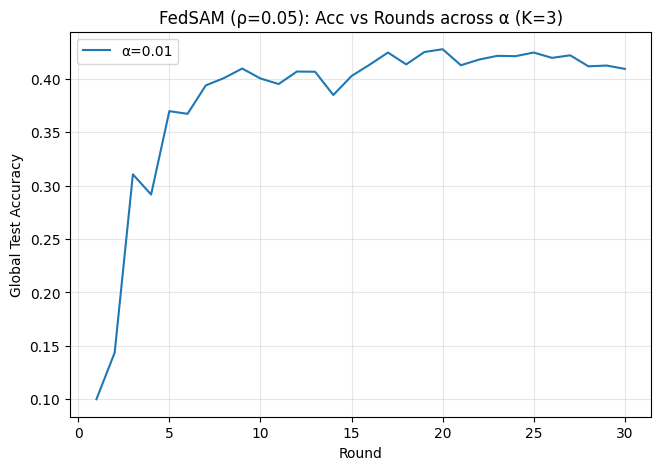

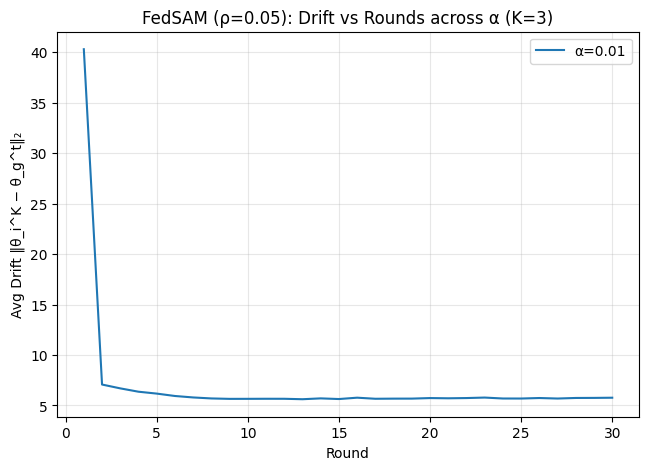

Saved FedSAM α-sweep figures to:
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task4_4_fedsam/fedsam_alpha_sweep_acc_rho0.05_K3.png
 - /content/drive/MyDrive/ATML_PA4_Task1_FedSGD/task4_4_fedsam/fedsam_alpha_sweep_drift_rho0.05_K3.png


In [ ]:
# ================================================================
# Run FedSAM across Dirichlet α values (fixed ρ), with class splits saved
# ================================================================
root_data = "/content/data"
train_set_full = datasets.CIFAR10(root=root_data, train=True,  download=True, transform=train_tf)

def run_task44_fedsam_alpha_sweep(
    alphas=(0.01,),
    K=3, rounds=30,
    lr=0.05, momentum=0.9, weight_decay=5e-4,
    rho=0.05,
    seeds=(0,),
    partition_seed=909,
    batch_size=64,
):
    results = {}
    for alpha in alphas:
        print("\n" + "="*72)
        print(f"[FedSAM α-sweep] Building Dirichlet split α={alpha} (seed={partition_seed})")
        print("="*72)

        split_dir = os.path.join(TASK44_DIR, f"alpha_{alpha}_rho_{rho}")
        os.makedirs(split_dir, exist_ok=True)

        client_idxs, class_hist = dirichlet_split_cifar10(
            train_set_full, num_clients=5, alpha=alpha, seed=partition_seed
        )
        client_loaders_local, client_sizes_local = build_client_loaders_from_indices(
            train_set_full, client_idxs, batch_size=batch_size, num_workers=2
        )

        # Save/print which client got which classes
        dist_df = save_class_distribution(alpha, class_hist, client_sizes_local, split_dir)
        display(dist_df)

        cfg = {
            "rounds": rounds, "K": K, "f": 1.0,
            "lr": lr, "momentum": momentum, "weight_decay": weight_decay,
            "rho": rho, "seeds": list(seeds), "eval_every": 1,
        }
        tag = f"fedsam_alpha_{alpha}_K{K}_rho{rho}"
        logs, csv_path, model_path = run_fedsam_experiment(
            cfg, tag, save_dir=split_dir,
            client_loaders=client_loaders_local, client_sizes=client_sizes_local,
            test_loader=test_loader, device=device
        )
        results[alpha] = (logs, csv_path, model_path, split_dir)

    # quick plots
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7.5,5.0))
    for alpha in alphas:
        df = pd.DataFrame(results[alpha][0])
        acc_curve = df.groupby("round")["test_acc"].mean()
        plt.plot(acc_curve.index, acc_curve.values, label=f"α={alpha}")
    plt.xlabel("Round"); plt.ylabel("Global Test Accuracy")
    plt.title(f"FedSAM (ρ={rho}): Acc vs Rounds across α (K={K})")
    plt.grid(True, alpha=0.3); plt.legend()
    fig_acc = os.path.join(TASK44_DIR, f"fedsam_alpha_sweep_acc_rho{rho}_K{K}.png")
    plt.savefig(fig_acc, dpi=150, bbox_inches='tight'); plt.show()

    plt.figure(figsize=(7.5,5.0))
    for alpha in alphas:
        df = pd.DataFrame(results[alpha][0])
        drift_curve = df.groupby("round")["drift_l2"].mean()
        plt.plot(drift_curve.index, drift_curve.values, label=f"α={alpha}")
    plt.xlabel("Round"); plt.ylabel("Avg Drift ‖θ_i^K − θ_g^t‖₂")
    plt.title(f"FedSAM (ρ={rho}): Drift vs Rounds across α (K={K})")
    plt.grid(True, alpha=0.3); plt.legend()
    fig_drift = os.path.join(TASK44_DIR, f"fedsam_alpha_sweep_drift_rho{rho}_K{K}.png")
    plt.savefig(fig_drift, dpi=150, bbox_inches='tight'); plt.show()

    print("Saved FedSAM α-sweep figures to:")
    print(" -", fig_acc)
    print(" -", fig_drift)
    return results

# ===== Run it (example) =====
fedsam_results = run_task44_fedsam_alpha_sweep(
    alphas=(0.01,),  # add 0.01 if you want an extreme case
    K=3, rounds=30,
    lr=0.05, momentum=0.9, weight_decay=5e-4,
    rho=0.05,         # report this in your writeup
    seeds=(0,),
    partition_seed=777, batch_size=64
)
